# Wamonyolo Studios Business Analysis  

##  Overview  
Wamonyolo Studios is planning to launch a new movie studio. To succeed, the company needs to understand what makes movies profitable. By analyzing past industry data, we can uncover insights that will guide Wamonyolo Studios toward smart, profit-driven decisions.  

---

##  Business Problem  
As a new player in the movie industry, Wamonyolo faces several key questions:  
-  How long should their films be?  
-  Which genres are the most profitable?  
-  Should they build their studio from scratch or acquire an existing one?
-  What is the optimal production budget for maximizing ROI?"
-  How important is the international box office for profitability?" 

Using industry datasets and analysis, we aim to answer these questions and shape a winning strategy.  

---

##  Data Preparation  
The **IMDb** dataset is the largest and most detailed. It provides:  
- Movie runtimes  
- Genres  
- Release years  
- Directors, writers, and actors  

**Limitation:** It does *not* include financial data like budgets or box office revenue.  

To complete the picture, we merge IMDb with financial datasets:  
- **Box Office Mojo (BOM):** Domestic + international box office gross  
- **The Numbers:** Budget + revenue  
- **The Movie DB (TMDB):** Ratings, popularity, and sometimes financial data  

This way, we connect *what a movie is* with *how it performs financially*.  

---

##  Why Merging Matters  
- **IMDb = What the movie is** (content + creators)  
- **Financial datasets = How the movie performed** (cost + revenue)  

When combined, the data allows us to answer:  
- Do longer films earn more or less?  
- Which genres deliver the highest returns?  
- Are certain directors/writers consistently successful?  

---
 
IMDb provides the richest descriptive information, but lacks financial details.  
By merging it with BOM, The Numbers, and TMDB, Wamonyolo Studios can analyze both creativity *and* profitability—ensuring a smart, data-driven entry into the movie market.  

# Import all necessary libraries

In [1]:
# Step 1: Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Reading the data 

In [2]:
# Box Office Mojo 
bom_movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')

# === The Numbers ===
tn_movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

# === The Movie Database (TMDb) ===
tmdb_movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')

# === Rotten Tomatoes ===
# === Rotten Tomatoes ===
rt_movies = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t', encoding='latin-1')
rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='latin-1')


IMDb.zip is basically a compressed folder with several .tsv IMDb files inside

In [3]:
import zipfile, pandas as pd

with zipfile.ZipFile('zippedData/im.db.zip') as z:
    print(z.namelist())   #  shows you all files inside



['im.db']


In [4]:
import zipfile

with zipfile.ZipFile("zippedData/im.db.zip", "r") as z:
    z.extractall("zippedData/")  # this will create 'zippedData/im.db'


The file contains  a single SQLite database File called im.db,meaning you need to open it as a SQLite database

In [5]:
import sqlite3
#import pandas as pd

conn = sqlite3.connect("zippedData/im.db")
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)



            name
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers


Now loading those tables into pandas DataFrames with simple SQL queriees

In [6]:
movie_basics = pd.read_sql("SELECT * FROM movie_basics;", conn)

directors = pd.read_sql("SELECT * FROM directors;", conn)
known_for = pd.read_sql("SELECT * FROM known_for;", conn)
movie_akas = pd.read_sql("SELECT * FROM movie_akas;", conn)
movie_ratings = pd.read_sql("SELECT * FROM movie_ratings;", conn)
persons = pd.read_sql("SELECT * FROM persons;", conn)
principals = pd.read_sql("SELECT * FROM principals;", conn)
writers = pd.read_sql("SELECT * FROM writers;", conn)

 # Data Cleaning 
We’ll clean only the datasets that are most useful for analysis (IMDb + financials). Rotten Tomatoes/TMDB can be optional later.

## Datasets to Clean First

1. IMDb tables (content & metadata)

  - movie_basics  (title, year, runtime, genres)

  - movie_ratings  (average rating, votes)

2. Box Office Mojo (bom_movie_gross)

 - Domestic & foreign gross

3. The Numbers (tn_movie_budgets)

 - Budget + gross

In [7]:
 movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [8]:
# Check duplicates
movie_basics.duplicated().sum()

np.int64(0)

In [9]:
# Convert datatypes

movie_basics = pd.read_sql("SELECT * FROM movie_basics;", conn)
movie_basics


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


### Step 1

Extract only the columns that we need 

In [10]:
runtime_df = movie_basics[['primary_title', 'start_year', 'runtime_minutes']]

 
- Movie_basics has many columns (genres, tconst, etc.), but for runtime analysis we only care about:

  1. Primary_title- movie name (for identification & merging later)

  2. Start_year - release year (to filter by time & merge with financial datasets)

  3. Runtime_minutes - our main feature of interest (movie length)


### Step 2 : 
Remove movies that haven't been released yet 

In [11]:
runtime_df = runtime_df[runtime_df['start_year'] < 2025]


Some rows have future release years (e.g., 2023, 2025).

Since we only analyze historical performance, those rows would give misleading results.

Keeps dataset consistent with financial data (which only has past films).

### Step 3

Drop row with missing runtimes 

In [12]:
runtime_df = runtime_df.dropna(axis=0, subset=['runtime_minutes'])


Missing runtimes = useless for analysis.

Dropping them ensures we don’t get NaN values messing up plots/stats.

### Step 4
Inspect the cleaned result

In [13]:
print(runtime_df.shape)     # how many rows/columns after cleaning
print(runtime_df.isna().sum())  # check if any nulls remain
runtime_df.head()           # preview first 5 rows
runtime_df.info()           # check datatypes
runtime_df.describe()       # quick stats (mean, min, max runtime)


(114405, 3)
primary_title      0
start_year         0
runtime_minutes    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 114405 entries, 0 to 146142
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   primary_title    114405 non-null  object 
 1   start_year       114405 non-null  int64  
 2   runtime_minutes  114405 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.5+ MB


,start_year,runtime_minutes
count,114405.000000,114405.000000
mean,2014.396801,86.187247
std,2.637480,166.360590
min,2010.000000,1.000000
25%,2012.000000,70.000000
50%,2014.000000,87.000000
75%,2017.000000,99.000000
max,2022.000000,51420.000000



- shape - see how much data we have left after cleaning.

- isna() - make sure runtimes are fully clean.

- head() - sanity check if columns look correct.

- info() - confirm datatypes (start_year should be int, runtime_minutes int/float).

- describe() - see runtime distribution (are there very short/long outliers?).

---

Now we’re prepping The Numbers and TMDb release dates so they can align with IMDb’s start_year.

In [14]:
tn_movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
tn_movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [15]:
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [16]:
#  The Movie Database (TMDb) 
tmdb_movies = pd.read_csv('zippedData/tmdb.movies.csv.gz', index_col=0)
tmdb_movies.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [17]:
tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26517 entries, 0 to 26516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genre_ids          26517 non-null  object 
 1   id                 26517 non-null  int64  
 2   original_language  26517 non-null  object 
 3   original_title     26517 non-null  object 
 4   popularity         26517 non-null  float64
 5   release_date       26517 non-null  object 
 6   title              26517 non-null  object 
 7   vote_average       26517 non-null  float64
 8   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 2.0+ MB


### Step 1

Convert release_date into datetime 

In [18]:
tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets['release_date'])
tmdb_movies['release_date'] = pd.to_datetime(tmdb_movies['release_date'])



Dates are often read in as strings → can’t extract year/month directly.

pd.to_datetime() standardizes them into true datetime objects.

### Step 2 
 
Extract release year (to match IMDb format)

In [19]:
tn_movie_budgets['release_year'] = tn_movie_budgets['release_date'].dt.year
tmdb_movies['release_year'] = tmdb_movies['release_date'].dt.year



IMDb uses just the year (start_year).

To merge datasets later, we need the same format (year only).

### Step 3: 
Extract release month (both numeric & string)

In [20]:
tn_movie_budgets['month_dt'] = tn_movie_budgets['release_date'].dt.month  # numeric month (1–12)
tn_movie_budgets['month'] = tn_movie_budgets['release_date'].dt.month     # duplicate here, can adjust if you want month names



Month helps analyze seasonality (e.g., summer blockbusters, holiday releases).

month_dt → numeric (for calculations).

month → could later be turned into month names for plots.

(Small note: you might want dt.month_name() if you prefer full names like “July”)

### Step 4:
Drop raw release_date

In [21]:
tn_movie_budgets = tn_movie_budgets.drop(columns=['release_date'])




We’ve extracted all useful parts (year + month).

Dropping avoids duplication and keeps dataframe cleaner.

### Step 5
Inspect

In [22]:
print(tn_movie_budgets[['movie','release_year','month_dt','month']].head())
print(tmdb_movies[['title','release_year']].head())


                                         movie  release_year  month_dt  month
0                                       Avatar          2009        12     12
1  Pirates of the Caribbean: On Stranger Tides          2011         5      5
2                                 Dark Phoenix          2019         6      6
3                      Avengers: Age of Ultron          2015         5      5
4            Star Wars Ep. VIII: The Last Jedi          2017        12     12
                                          title  release_year
0  Harry Potter and the Deathly Hallows: Part 1          2010
1                      How to Train Your Dragon          2010
2                                    Iron Man 2          2010
3                                     Toy Story          1995
4                                     Inception          2010


- Now you’re cleaning up the financial columns from The Numbers so they’re ready for calculations and plots. 

### Step 1:
Identify the money columns

In [23]:
cols = ['production_budget', 'domestic_gross', 'worldwide_gross']



These are stored as strings with $ and commas (e.g.,       "$100,000,000").
We can’t do math or plots with strings → must convert to numbers.

### Step 2:
Remove $ and ,

In [24]:
tn_movie_budgets[cols] = tn_movie_budgets[cols].replace('[\$,]', '', regex=True)


<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
C:\Users\Ray Onsongo\AppData\Local\Temp\ipykernel_9868\698015300.py:1: SyntaxWarning: invalid escape sequence '\$'
  tn_movie_budgets[cols] = tn_movie_budgets[cols].replace('[\$,]', '', regex=True)




[\$,] means: match dollar signs $ or commas ,.

.replace(..., regex=True) strips them out → "100000000".

### Step 3: 
Convert to integers

In [25]:
tn_movie_budgets[cols] = tn_movie_budgets[cols].astype('int64')




Converts cleaned strings into integers so we can:

Calculate profits/losses

Plot histograms, scatterplots

Run regressions

Step 4 Inspect the result

In [26]:
print(tn_movie_budgets[cols].dtypes)   # confirm int64
tn_movie_budgets[cols].describe()      # check ranges, averages, etc.
tn_movie_budgets.head(3)               # preview cleaned values


production_budget    int64
domestic_gross       int64
worldwide_gross      int64
dtype: object


,id,movie,production_budget,domestic_gross,worldwide_gross,release_year,month_dt,month
0,1,Avatar,425000000,760507625,2776345279,2009,12,12
1,2,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,5,5
2,3,Dark Phoenix,350000000,42762350,149762350,2019,6,6




describe() shows if values are realistic (e.g., budgets in millions, not billions).

# Standardizing titles across all datasets to improve your merge success rate

### Step 1:
Apply .str.title() to titles

In [27]:
runtime_df['primary_title'] = runtime_df['primary_title'].str.title()
tn_movie_budgets['movie'] = tn_movie_budgets['movie'].str.title()
bom_movie_gross['title'] = bom_movie_gross['title'].str.title()
tmdb_movies['title'] = tmdb_movies['title'].str.title()



- In different datasets, titles may appear as "avatar", "Avatar", or "AVATAR". .str.title() converts them all to "Avatar" → making matches more consistent when merging.

### Step 2: 
Inspect for consistency

In [28]:
print(runtime_df['primary_title'].head(5))
print(tn_movie_budgets['movie'].head(5))
print(bom_movie_gross['title'].head(5))
print(tmdb_movies['title'].head(5))

0                          Sunghursh
1    One Day Before The Rainy Season
2         The Other Side Of The Wind
4           The Wandering Soap Opera
5                        A Thin Life
Name: primary_title, dtype: object
0                                         Avatar
1    Pirates Of The Caribbean: On Stranger Tides
2                                   Dark Phoenix
3                        Avengers: Age Of Ultron
4              Star Wars Ep. Viii: The Last Jedi
Name: movie, dtype: object
0                                    Toy Story 3
1                     Alice In Wonderland (2010)
2    Harry Potter And The Deathly Hallows Part 1
3                                      Inception
4                            Shrek Forever After
Name: title, dtype: object
0    Harry Potter And The Deathly Hallows: Part 1
1                        How To Train Your Dragon
2                                      Iron Man 2
3                                       Toy Story
4                                   

- Now you’re adding profit margin columns so you can analyze which movies actually made money relative to their costs.(tn_movie_budgets)

### Step 1: 
Domestic profit margin

In [29]:
tn_movie_budgets['dom_profit_margin'] = (
    (tn_movie_budgets['domestic_gross'] - tn_movie_budgets['production_budget'])
    / tn_movie_budgets['domestic_gross']
) * 100


Formula:
Profit Margin
=
Revenue − CostRevenue × 100

Profit Margin = Revenue − Cost Revenue × 100

Tells you what % of revenue was actual profit from U.S. box office only.

### Step 2: 
Worldwide profit margin

In [30]:
tn_movie_budgets['ww_profit_margin'] = (
    (tn_movie_budgets['worldwide_gross'] - tn_movie_budgets['production_budget'])
    / tn_movie_budgets['worldwide_gross']
) * 100


- Same idea, but using global revenue. Helps you see if movies depended more on domestic vs international markets for profitability.

### Step 3: 
Inspect results

In [31]:
tn_movie_budgets[['movie','production_budget','domestic_gross','worldwide_gross','dom_profit_margin','ww_profit_margin']].head(10)


,movie,production_budget,domestic_gross,worldwide_gross,dom_profit_margin,ww_profit_margin
0,Avatar,425000000,760507625,2776345279,44.116274,84.692106
1,Pirates Of The Caribbean: On Stranger Tides,410600000,241063875,1045663875,-70.328300,60.733080
2,Dark Phoenix,350000000,42762350,149762350,-718.477001,-133.703598
3,Avengers: Age Of Ultron,330600000,459005868,1403013963,27.974777,76.436443
4,Star Wars Ep. Viii: The Last Jedi,317000000,620181382,1316721747,48.885921,75.925058
5,Star Wars Ep. Vii: The Force Awakens,306000000,936662225,2053311220,67.330806,85.097242
6,Avengers: Infinity War,300000000,678815482,2048134200,55.805369,85.352522
7,Pirates Of The Caribbean: At WorldâS End,300000000,309420425,963420425,3.044539,68.860947
8,Justice League,300000000,229024295,655945209,-30.990470,54.264473
9,Spectre,300000000,200074175,879620923,-49.944389,65.894399


- This structure is like we did for profit margins, but now for profit amount and ROI — and using our dataset (tn_movie_budgets).

### Step 4: 
Worldwide profit amount

In [32]:
tn_movie_budgets['world_wide_profit_amount'] = (
    tn_movie_budgets['worldwide_gross'] - tn_movie_budgets['production_budget']
)


This gives you the absolute dollar profit (or loss) a movie made globally. Unlike margins, this shows the real money gained. Example: If budget = $100M, worldwide gross = $250M, then Profit = $150M.

### Step 5: 
Return on Investment (ROI)

In [33]:
tn_movie_budgets['ROI_perc'] = (
    tn_movie_budgets['world_wide_profit_amount'] / tn_movie_budgets['production_budget']
) * 100


ROI tells you how efficiently money was used.

Formula:

𝑅
𝑂
𝐼
=
(Net Profit / Budget) × 100

ROI=
Budget
Net Profit
	​

×100

A blockbuster making 200M dollar profit on a 200M dollar budget → ROI = 100% , but a small film making 20M dollar profit on $5M dollar budget → ROI = 400% therefore ROI highlights hidden winners among low-budget films.

### Step 6:
Inspect results

In [34]:
print(tn_movie_budgets['release_year'].unique()[:20])
print(tn_movie_budgets['release_year'].dtype)

[2009 2011 2019 2015 2017 2018 2007 2012 2013 2010 2016 2014 2006 2008
 2005 1997 2004 1999 1995 2003]
int32


In [35]:
tn_movie_budgets[['movie','production_budget','worldwide_gross',
                  'world_wide_profit_amount','ROI_perc']].head(10)

,movie,production_budget,worldwide_gross,world_wide_profit_amount,ROI_perc
0,Avatar,425000000,2776345279,2351345279,553.257713
1,Pirates Of The Caribbean: On Stranger Tides,410600000,1045663875,635063875,154.667286
2,Dark Phoenix,350000000,149762350,-200237650,-57.210757
3,Avengers: Age Of Ultron,330600000,1403013963,1072413963,324.384139
4,Star Wars Ep. Viii: The Last Jedi,317000000,1316721747,999721747,315.369636
5,Star Wars Ep. Vii: The Force Awakens,306000000,2053311220,1747311220,571.016739
6,Avengers: Infinity War,300000000,2048134200,1748134200,582.711400
7,Pirates Of The Caribbean: At WorldâS End,300000000,963420425,663420425,221.140142
8,Justice League,300000000,655945209,355945209,118.648403
9,Spectre,300000000,879620923,579620923,193.206974


- Now we can filter the dataset by year from the tn_movie_budgets DataFrame.

In [36]:
tn_movie_budgets= tn_movie_budgets[tn_movie_budgets['release_year'] > 2000]


In [37]:
print(tn_movie_budgets.shape)
print(tn_movie_budgets['release_year'].min(), tn_movie_budgets['release_year'].max())



(4198, 12)
2001 2020


In [38]:
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4198 entries, 0 to 5781
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        4198 non-null   int64  
 1   movie                     4198 non-null   object 
 2   production_budget         4198 non-null   int64  
 3   domestic_gross            4198 non-null   int64  
 4   worldwide_gross           4198 non-null   int64  
 5   release_year              4198 non-null   int32  
 6   month_dt                  4198 non-null   int32  
 7   month                     4198 non-null   int32  
 8   dom_profit_margin         4198 non-null   float64
 9   ww_profit_margin          4198 non-null   float64
 10  world_wide_profit_amount  4198 non-null   int64  
 11  ROI_perc                  4198 non-null   float64
dtypes: float64(3), int32(3), int64(5), object(1)
memory usage: 377.2+ KB


- Older movies (before 2000) may not reflect today’s industry dynamics. Budgets, marketing, and box office models changed drastically in the 2025s (e.g., streaming, globalization).

# Shifting into release month analysis. 
- Since we are using tn_movie_budgets instead of numbers_df, let’s rewrite and break it down:

 Step 1: Group by release month and calculate medians

In [39]:
# First, ensure your 'month' column is clean and numeric.
# Then, select only the numeric columns for the median calculation.
# These likely include 'production_budget', 'domestic_gross', 'worldwide_gross', 'worldwide_profit', 'roi'

numeric_columns = ['production_budget', 'domestic_gross', 'worldwide_gross', 'world_wide_profit_amount', 'month']  # Add any other numeric columns you have

# Create a DataFrame with only the numeric columns and the 'month' for grouping
numeric_df = tn_movie_budgets[numeric_columns]

# Now group by 'month' and calculate the median for the remaining numeric columns
month_df = numeric_df.groupby('month').median()

# Reset index so 'month' becomes a column again
month_df = month_df.reset_index()

# Sort by month number (1–12)
month_df = month_df.sort_values('month')

# Add month names
month_dict = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
month_df['month_name'] = month_df['month'].map(month_dict)

# Display the result
print(month_df)

    month  production_budget  domestic_gross  worldwide_gross  \
0       1         18000000.0      17469107.0       35260470.0   
1       2         20000000.0      19192510.0       39049922.0   
2       3         18000000.0      16127344.5       25802739.5   
3       4         17250000.0      11453108.0       21673225.5   
4       5         20000000.0      18882880.0       38158601.0   
5       6         21750000.0      21457839.5       42609137.0   
6       7         20000000.0      27397912.5       50397206.5   
7       8         20000000.0      16521410.0       30138912.0   
8       9         16250000.0      10300039.5       21702186.0   
9      10         13000000.0       8050767.0       15486441.5   
10     11         25000000.0      26900336.0       52427346.0   
11     12         19200000.0       6107205.5       23514312.0   

    world_wide_profit_amount month_name  
0                 11131779.0        Jan  
1                 13874967.0        Feb  
2                  7875084.0

- Grouping by month lets you see if certain months tend to produce higher profits/ROI. 
- Using the median reduces the impact of extreme outliers (e.g., Avengers making billions).
- Sorting ensures the months are in calendar order.
- Adding names (Jan, Feb, etc.) makes plots readable.

# Merging

## The Numbers (box office + budget) with IMDb

### Merge datasets on title + year

In [40]:
print(tn_movie_budgets['release_year'].unique()[:20])
print(runtime_df['start_year'].unique()[:20])

[2009 2011 2019 2015 2017 2018 2007 2012 2013 2010 2016 2014 2006 2008
 2005 2004 2003 2001 2020 2002]
[2013 2019 2018 2017 2012 2010 2011 2015 2016 2014 2020 2022 2021]


In [41]:
overlap_years = set(tn_movie_budgets['release_year']).intersection(set(runtime_df['start_year']))
print("Overlap years:", overlap_years)

Overlap years: {2016, 2017, 2018, 2019, 2020, 2010, 2011, 2012, 2013, 2014, 2015}


In [42]:
tn_2019 = tn_movie_budgets[tn_movie_budgets['release_year'] == 2019]['movie'].unique()
imdb_2019 = runtime_df[runtime_df['start_year'] == 2019]['primary_title'].unique()

print("The Numbers (2019) sample:", tn_2019[:20])
print("IMDb (2019) sample:", imdb_2019[:20])

The Numbers (2019) sample: ['Dark Phoenix' 'Aladdin' 'Captain Marvel' 'Dumbo' 'Alita: Battle Angel'
 'Godzilla: King Of The Monsters' 'Pokã©Mon: Detective Pikachu'
 'How To Train Your Dragon: The Hidden World'
 'Men In Black: International' 'Wonder Park'
 'The Lego Movie 2: The Second Part' 'Army Of The Dead' 'Shazam!'
 'The Secret Life Of Pets 2' 'Renegades' 'Playmobil' '355'
 'A Dogâ\x80\x99S Way Home' 'Cold Pursuit' 'Midway']
IMDb (2019) sample: ['One Day Before The Rainy Season' 'Alita: Battle Angel' 'Shazam!'
 'The Legend Of Secret Pass' 'The Dirt' 'Pet Sematary' 'Bolden'
 'Disrupted Land' 'Fiddler: A Miracle Of Miracles' 'Soccer In The City'
 'When I Became A Butterfly' 'Paradise' 'Aporia' 'Debout' 'Krishnam'
 'Kala-A-Zar' 'Terror In The Skies' 'Bull' 'Troublemaker' 'Snatchers']


In [43]:
numbers_and_runtime = tn_movie_budgets.merge(
    runtime_df,
    left_on=['movie', 'release_year'],
    right_on=['primary_title', 'start_year'],
    how='inner'
)
# Keep only movies with valid domestic gross
numbers_and_runtime = numbers_and_runtime.loc[numbers_and_runtime['domestic_gross'] > 0]

- Merge on both title + year. Some movies share the same title (Halloween 1978 vs Halloween 2018). Matching with year avoids wrong matches.
- Inner join (how='inner'). Keeps only rows where a movie exists in both datasets so each row has financial data + runtime.
- Filter out domestic_gross == 0. Removes movies that never played in theaters in the U.S. Ensures analysis is focused on box office performers.

# Inspect merged results

In [44]:
print(numbers_and_runtime.shape)
numbers_and_runtime.head()
numbers_and_runtime.info()

(1395, 15)
<class 'pandas.core.frame.DataFrame'>
Index: 1395 entries, 0 to 1558
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1395 non-null   int64  
 1   movie                     1395 non-null   object 
 2   production_budget         1395 non-null   int64  
 3   domestic_gross            1395 non-null   int64  
 4   worldwide_gross           1395 non-null   int64  
 5   release_year              1395 non-null   int32  
 6   month_dt                  1395 non-null   int32  
 7   month                     1395 non-null   int32  
 8   dom_profit_margin         1395 non-null   float64
 9   ww_profit_margin          1395 non-null   float64
 10  world_wide_profit_amount  1395 non-null   int64  
 11  ROI_perc                  1395 non-null   float64
 12  primary_title             1395 non-null   object 
 13  start_year                1395 non-null   int64  
 14  ru

# Creating dataframe with studio and box office data

### Step 1: 
Select relevant columns from Box Office Mojo
We only need the movie title, studio, and release year from BOM because these are the identifiers we will merge with The Numbers dataset.

In [45]:
# Selecting only the necessary columns from BOM
studio_df = bom_movie_gross [['title', 'studio', 'year']]

### Step 2: 
Merge with The Numbers dataset

- Now we merge studio_df with tn_movie_budgets to attach financial data (budget, domestic gross, worldwide gross) to each movie.

In [46]:
# Merge studio info from BOM with financial info from The Numbers
studio_df = studio_df.merge(
    tn_movie_budgets,             # TN dataset with budgets & grosses
    left_on=['title', 'year'],    # BOM columns to merge on
    right_on=['movie', 'release_year'], # TN columns to merge on
    how='inner'                   # Only keep movies that exist in both datasets
)


- Some movies may have the same title but are different movies released in different years. Matching only by title could create incorrect combinations.

### Step 3: 
Inspect the merged dataframe

In [47]:
# Check the shape of the new dataframe
print(studio_df.shape)

(1255, 15)


In [48]:
# Preview the first 10 rows
studio_df.head(10)

,title,studio,year,id,movie,production_budget,domestic_gross,worldwide_gross,release_year,month_dt,month,dom_profit_margin,ww_profit_margin,world_wide_profit_amount,ROI_perc
0,Toy Story 3,BV,2010,47,Toy Story 3,200000000,415004880,1068879522,2010,6,6,51.807796,81.288817,868879522,434.439761
1,Inception,WB,2010,38,Inception,160000000,292576195,835524642,2010,7,7,45.313391,80.850355,675524642,422.202901
2,Shrek Forever After,P/DW,2010,27,Shrek Forever After,165000000,238736787,756244673,2010,5,5,30.886227,78.181664,591244673,358.330105
3,The Twilight Saga: Eclipse,Sum.,2010,53,The Twilight Saga: Eclipse,68000000,300531751,706102828,2010,6,6,77.373439,90.369675,638102828,938.386512
4,Iron Man 2,Par.,2010,15,Iron Man 2,170000000,312433331,621156389,2010,5,5,45.588392,72.631691,451156389,265.386111
5,Tangled,BV,2010,15,Tangled,260000000,200821936,586477240,2010,11,11,-29.467928,55.667504,326477240,125.568169
6,Despicable Me,Uni.,2010,50,Despicable Me,69000000,251513985,543464573,2010,7,7,72.566138,87.303680,474464573,687.629816
7,How To Train Your Dragon,P/DW,2010,30,How To Train Your Dragon,165000000,217581232,494870992,2010,3,3,24.166253,66.657977,329870992,199.921813
8,The Chronicles Of Narnia: The Voyage Of The Da...,Fox,2010,48,The Chronicles Of Narnia: The Voyage Of The Da...,155000000,104386950,418186950,2010,12,12,-48.485994,62.935237,263186950,169.798032
9,The Karate Kid,Sony,2010,77,The Karate Kid,40000000,176591618,351774938,2010,6,6,77.348868,88.629093,311774938,779.437345


# Calculating average studio-level metrics

### Step 1: 
Group by studio

In [49]:
numeric_columns = ['production_budget', 'domestic_gross', 'worldwide_gross', 'world_wide_profit_amount', 'dom_profit_margin', 'ww_profit_margin', 'ROI_perc']  # Add any others you have

# Now, group by 'studio' but only for the numeric columns.
# This creates a DataFrame where the index is the studio, and the values are the means of the numeric columns.
avg_studio = studio_df.groupby('studio')[numeric_columns].mean()

# Reset the index to turn 'studio' from the index back into a regular column
avg_studio = avg_studio.reset_index()

- We want to see studio-level performance rather than movie-level. Grouping and averaging helps us identify which studios consistently produce profitable movies.
- Groupby('studio') - Groups all movies by their production studio.
- .mean() - Calculates the average of all numeric columns for each studio, e.g., production_budget, domestic_gross, worldwide_gross, dom_profit_margin, ww_profit_margin, ROI_perc.
- .reset_index() - Converts the grouped index (studio) back into a regular column so we can easily access and plot it.

### Step 2: 
Filter only profitable studios

In [50]:
avg_studio = avg_studio[avg_studio['dom_profit_margin'] > 0]

- Negative-profit studios can skew analysis and plots.Focusing on positive-profit studios helps highlight the best-performing studios.
- Setting ***dom_profit_margin*** > 0 keeps only studios whose average domestic profit margin is positive. This removes studios that on average lose money domestically, so analysis focuses on studios that are financially successful.

In [51]:
print(avg_studio.shape)   # How many studios are left after filtering
print(avg_studio.head(5)) # Preview the first 10 studios with average metrics

(14, 8)
     studio  production_budget  domestic_gross  worldwide_gross  \
0        3D       5.000000e+06    6.096582e+06     1.651520e+07   
3    Affirm       3.500000e+06    1.167510e+07     1.573575e+07   
11  BH Tilt       2.800000e+06    8.717903e+06     1.323772e+07   
15      CBS       2.063636e+07    2.758124e+07     5.372220e+07   
48     MBox       2.600000e+06    3.827060e+06     1.529836e+07   

    world_wide_profit_amount  dom_profit_margin  ww_profit_margin    ROI_perc  
0               1.151520e+07          17.986833         69.724865  230.304060  
3               1.223575e+07          68.518543         73.378039  303.844830  
11              1.043772e+07          61.680377         75.599998  689.651002  
15              3.308584e+07          11.384555         47.923730  221.347979  
48              1.269836e+07          32.062732         83.004709  488.398269  


# Merging The Numbers with TMDb to analyze genres

## Merge datasets

In [52]:
genre_df = tn_movie_budgets.merge(tmdb_movies, left_on=['movie', 'release_year'], right_on=['title', 'release_year'])

To analyze profitability by genre, we need both financial info and genre info in the same DataFrame.

In [53]:
genre_df.loc[:,'genre_ids'] = genre_df['genre_ids'].map(lambda genre_string: genre_string.strip('[]').split(', '))

- TMDb assigns multiple genres to a movie. Splitting into a list prepares it for exploding later, so each movie-genre combination becomes a separate row for analysis.
- genre_ids in TMDb is a string like "[28, 12, 878]".

- strip('[]')  removes the square brackets.
- split(', ')  converts the string into a list of genre IDs

In [54]:
genre_df = genre_df.loc[(genre_df['worldwide_gross'] > 0) & (genre_df['domestic_gross'] > 0)]
genre_ids_df = genre_df.explode('genre_ids')

- Keep only movies with revenue. We only want movies that actually earned money, to calculate meaningful profitability metrics by genre.
- Explode('genre_ids') - creates one row per movie per genre. If a movie has 3 genres, it will now appear in 3 rows, one for each genre. Allows aggregation of financial metrics per genre, not per movie.

# Map genre IDs to names

In [55]:
# Step 1: Map genre_ids to readable genre names using a dictionary
genre_map = {
    '28': 'Action', '12': 'Adventure', '16': 'Animation', '35': 'Comedy', '80': 'Crime',
    '99': 'Documentary', '18': 'Drama', '10751': 'Family', '14': 'Fantasy', '36': 'History',
    '27': 'Horror', '10402': 'Music', '9648': 'Mystery', '10749': 'Romance', '878': 'Sci-Fi',
    '10770': 'TV Movie', '53': 'Thriller', '10752': 'War', '37': 'Western'
}
# Step 2: Add a new column for readable genre names
genre_ids_df['genre_name'] = genre_ids_df['genre_ids'].map(genre_map)
# Step 3: Inspect the resulting dataframe
print(genre_ids_df[['movie', 'production_budget', 'domestic_gross', 'worldwide_gross', 'ROI_perc', 'genre_name']].head())

                                         movie  production_budget  \
0                                       Avatar          425000000   
0                                       Avatar          425000000   
0                                       Avatar          425000000   
0                                       Avatar          425000000   
1  Pirates Of The Caribbean: On Stranger Tides          410600000   

   domestic_gross  worldwide_gross    ROI_perc genre_name  
0       760507625       2776345279  553.257713     Action  
0       760507625       2776345279  553.257713  Adventure  
0       760507625       2776345279  553.257713    Fantasy  
0       760507625       2776345279  553.257713     Sci-Fi  
1       241063875       1045663875  154.667286  Adventure  


genre_map  Provides a mapping from TMDb’s numeric IDs to human-readable genre names.

map()  Converts each genre_id in genre_ids_df to its corresponding genre_name.
now have a clean dataset (genre_ids_df) with financials and readable genres, ready for aggregation like calculating mean ROI per genre.


In [56]:
genre_ids_df.head()

,id_x,movie,production_budget,domestic_gross,worldwide_gross,release_year,month_dt,month,dom_profit_margin,ww_profit_margin,...,genre_ids,id_y,original_language,original_title,popularity,release_date,title,vote_average,vote_count,genre_name
0,1,Avatar,425000000,760507625,2776345279,2009,12,12,44.116274,84.692106,...,28,19995,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676,Action
0,1,Avatar,425000000,760507625,2776345279,2009,12,12,44.116274,84.692106,...,12,19995,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676,Adventure
0,1,Avatar,425000000,760507625,2776345279,2009,12,12,44.116274,84.692106,...,14,19995,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676,Fantasy
0,1,Avatar,425000000,760507625,2776345279,2009,12,12,44.116274,84.692106,...,878,19995,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676,Sci-Fi
1,2,Pirates Of The Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,5,5,-70.328300,60.733080,...,12,1865,en,Pirates of the Caribbean: On Stranger Tides,30.579,2011-05-20,Pirates Of The Caribbean: On Stranger Tides,6.4,8571,Adventure


In [57]:
# Rename the correct genre_name column
# Keep genre_name_y (from converter) and drop genre_name_x
genre_overall = genre_ids_df.rename(columns={'genre_name_y': 'genre_name'})

# Drop duplicate or unnecessary columns
genre_overall = genre_overall.drop(columns=['genre_name_x', 'id_x', 'id_y', 'Unnamed: 0'], errors='ignore')

# Keep only the useful columns
genre_overall_clean = genre_overall[[
    'movie',
    'release_year',
    'production_budget',
    'domestic_gross',
    'worldwide_gross',
    'ROI_perc',
    'genre_ids',
    'genre_name',
    'month',        # <-- keep this
    'month_dt'      # <-- and this
]]

print(genre_overall_clean.head())

                                         movie  release_year  \
0                                       Avatar          2009   
0                                       Avatar          2009   
0                                       Avatar          2009   
0                                       Avatar          2009   
1  Pirates Of The Caribbean: On Stranger Tides          2011   

   production_budget  domestic_gross  worldwide_gross    ROI_perc genre_ids  \
0          425000000       760507625       2776345279  553.257713        28   
0          425000000       760507625       2776345279  553.257713        12   
0          425000000       760507625       2776345279  553.257713        14   
0          425000000       760507625       2776345279  553.257713       878   
1          410600000       241063875       1045663875  154.667286        12   

  genre_name  month  month_dt  
0     Action     12        12  
0  Adventure     12        12  
0    Fantasy     12        12  
0     Sci-Fi

- tmdb_movies → raw TMDb data with columns like title, release_date, genre_ids (as strings like "[28, 12, 878]").

- genre_df → merged tn_movie_budgets + tmdb_movies to bring financials together with genre_ids.

- genre_ids_df → exploded version of genre_df['genre_ids'], so each row now represents one movie–one genre instead of a list of IDs.

In [58]:
print(genre_overall.columns)

Index(['movie', 'production_budget', 'domestic_gross', 'worldwide_gross',
       'release_year', 'month_dt', 'month', 'dom_profit_margin',
       'ww_profit_margin', 'world_wide_profit_amount', 'ROI_perc', 'genre_ids',
       'original_language', 'original_title', 'popularity', 'release_date',
       'title', 'vote_average', 'vote_count', 'genre_name'],
      dtype='object')


TMDb only gives numeric IDs in genre_ids.

We need readable genre names to analyze which genres are most profitable.

# Analyze profitability by genre

# Group by genre Mean version(average)

In [59]:
#Group by genre_name, calculate mean of financial metrics
genre_groups = genre_overall_clean.groupby('genre_name').mean(numeric_only=True)

#  Sort by ROI_perc and pick top 7 genres
genre_groups = genre_groups.sort_values('ROI_perc', ascending=False).head(7)

print(genre_groups)

            release_year  production_budget  domestic_gross  worldwide_gross  \
genre_name                                                                     
Horror       2014.006061       2.291297e+07    3.915706e+07     9.026821e+07   
Thriller     2013.623288       3.731461e+07    4.332908e+07     1.084243e+08   
Mystery      2013.771186       3.295345e+07    4.284843e+07     1.021399e+08   
Romance      2013.214953       2.846243e+07    4.188975e+07     9.342080e+07   
Animation    2014.290909       1.003909e+08    1.393303e+08     3.849198e+08   
Sci-Fi       2014.258537       9.271988e+07    1.123468e+08     3.077264e+08   
Music        2014.019608       2.693529e+07    4.828898e+07     9.604752e+07   

               ROI_perc     month  month_dt  
genre_name                                   
Horror      1069.092677  6.369697  6.369697  
Thriller     436.286887  6.860731  6.860731  
Mystery      436.142740  7.076271  7.076271  
Romance      291.691268  6.738318  6.738318  
Ani

- We are grouping by genre_name and calculating the average financial metrics (like ROI, budget, and gross) because we want to find out which genres are the most profitable on average. By grouping, we turn many individual movies into a single “genre profile.” By taking the mean, we can compare genres fairly, instead of looking at random single movies. By sorting by ROI, we highlight which genres give the highest return on investment — this tells us where money is being made most efficiently. Finally, limiting to the top 7 gives us a focused view of the genres that perform the best, so the analysis is actionable.

- What it does:(Mean) - Takes the average ROI, budget, gross, etc. across all movies in each genre.

- Pros:

1. Captures the overall profitability of the genre.

2. Good if you want the "expected value" of investing in that genre.

- Cons:
1. Sensitive to outliers (e.g., one mega-hit Marvel movie can make "Superhero" genre look insanely profitable, even if most films lose money).

#  Median version (middle value)


In [60]:
# Group by genre_name and calculate the median of numeric columns
genre_groups_med = genre_overall_clean.groupby('genre_name').median(numeric_only=True)

# Sort by ROI_perc and keep top 7 genres
genre_groups_med = genre_groups_med.sort_values('ROI_perc', ascending=False).head(7)

print(genre_groups_med)

            release_year  production_budget  domestic_gross  worldwide_gross  \
genre_name                                                                     
Horror            2014.0         10000000.0      29136626.0       59922558.0   
Animation         2015.0         87500000.0     121440343.5      327829122.5   
Adventure         2015.0        110000000.0      93432655.0      282778100.0   
Family            2014.0         78000000.0      82051601.0      200859554.0   
Fantasy           2014.0         90000000.0      68549695.0      213691277.0   
Mystery           2015.0         21500000.0      30322525.0       63757397.0   
Comedy            2014.0         28000000.0      37915414.0       67130045.0   

              ROI_perc  month  month_dt  
genre_name                               
Horror      231.669132    7.0       7.0  
Animation   200.418943    7.0       7.0  
Adventure   167.114096    7.0       7.0  
Family      166.547080    7.0       7.0  
Fantasy     165.951426    7

- We already looked at average ROI per genre using the mean. That gave us a sense of overall profitability but was sensitive to outliers (e.g., one mega-hit movie making a genre look profitable even if most others flopped).

- What it does: Takes the median (middle) ROI, budget, gross, etc. for movies in each genre.

- Pros:

1. Shows what the typical movie in the genre earns.

2. More robust against extreme values (one flop or one blockbuster won’t skew results).

Cons:

1. Doesn’t capture the impact of extreme successes, which are important in the film industry (because a few blockbusters can fund the entire studio). 

***N/B***
- Mean = overall average performance of the genre → influenced by big winners and losers.

- Median = typical performance of the genre → tells you what a "normal" movie in that genre does.

In [61]:
# Filter Horror movies only
horror_month_df = genre_overall_clean[genre_overall_clean['genre_name'] == 'Horror']

# Drop very low earners
horror_month_df = horror_month_df[horror_month_df['worldwide_gross'] > 100000]

# Group by release month and take the median of numeric columns
horror_month_df = horror_month_df.groupby('month').median(numeric_only=True).reset_index()

# Sort by calendar order (month_dt ensures Jan -> Dec)
horror_month_df = horror_month_df.sort_values('month_dt')

# Map month numbers to names
month_dict = {
    1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun",
    7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"
}
horror_month_df['month_name'] = horror_month_df['month'].map(month_dict)

print(horror_month_df.head())


   month  release_year  production_budget  domestic_gross  worldwide_gross  \
0      1        2014.0         12500000.0      33694789.0       77892256.0   
1      2        2014.0         10000000.0      26797294.0       48461873.5   
2      3        2015.0          5000000.0      14674077.0       23250755.0   
3      4        2013.5          5000000.0      35485286.5       67527083.0   
4      5        2015.0         35000000.0      29136626.0       84154026.0   

     ROI_perc  month_dt month_name  
0  325.677601       1.0        Jan  
1  475.462447       2.0        Feb  
2  499.201020       3.0        Mar  
3  333.270935       4.0        Apr  
4  145.898193       5.0        May  


I filter the dataset down to Horror movies and drop tiny releases (worldwide_gross > 100000).

I group those movies by release month and take the median of numeric metrics (so we see the typical horror movie performance per month).

I reset the index and sort by month_dt so months appear in calendar order (Jan - Dec).

I map month numbers to readable month names (Jan, Feb, ...) so the table is easy to read and plot.

# Simple Linear Regression anaysis 

- An overview of the datasets we will use for this:

In [62]:
display(horror_month_df.describe())
display(avg_studio.describe())
display(genre_overall_clean.describe())

,month,release_year,production_budget,domestic_gross,worldwide_gross,ROI_perc,month_dt
count,12.000000,12.000000,1.200000e+01,1.200000e+01,1.200000e+01,12.000000,12.000000
mean,6.500000,2014.375000,1.225000e+07,2.967463e+07,6.444484e+07,354.721341,6.500000
std,3.605551,1.130668,7.981513e+06,1.267051e+07,2.953579e+07,268.683956,3.605551
min,1.000000,2012.500000,5.000000e+06,6.810754e+06,8.890094e+06,87.420720,1.000000
25%,3.750000,2013.875000,9.000000e+06,2.127689e+07,4.609280e+07,215.755023,3.750000
50%,6.500000,2014.000000,1.050000e+07,3.137490e+07,7.166126e+07,299.898476,6.500000
75%,9.250000,2015.125000,1.312500e+07,3.522970e+07,8.241241e+07,390.501129,9.250000
max,12.000000,2016.000000,3.500000e+07,4.959554e+07,1.050150e+08,1112.211863,12.000000


,production_budget,domestic_gross,worldwide_gross,world_wide_profit_amount,dom_profit_margin,ww_profit_margin,ROI_perc
count,1.400000e+01,1.400000e+01,1.400000e+01,1.400000e+01,14.000000,14.000000,14.000000
mean,2.756587e+07,4.143936e+07,9.974835e+07,7.218248e+07,34.775649,66.245899,476.523624
std,3.708456e+07,4.761739e+07,1.369205e+08,1.002492e+08,22.123616,13.546435,371.478565
min,2.500000e+06,3.827060e+06,1.323772e+07,6.704317e+06,1.574618,46.833530,205.213397
25%,3.875000e+06,9.457203e+06,1.593061e+07,1.235140e+07,19.559690,54.784204,243.356975
50%,9.325000e+06,2.260992e+07,4.436142e+07,3.079324e+07,34.276450,67.147950,320.355018
75%,3.841071e+07,6.946566e+07,1.260143e+08,8.760357e+07,50.476864,75.044508,555.441756
max,1.334000e+08,1.682915e+08,5.078028e+08,3.744028e+08,68.518543,89.515856,1574.515218


,release_year,production_budget,domestic_gross,worldwide_gross,ROI_perc,month,month_dt
count,4138.000000,4.138000e+03,4.138000e+03,4.138000e+03,4138.000000,4138.000000,4138.000000
mean,2013.831078,5.534669e+07,6.936900e+07,1.794672e+08,290.635152,7.044949,7.044949
std,2.728950,6.137537e+07,9.619419e+07,2.692222e+08,1084.418256,3.453326,3.453326
min,2001.000000,3.000000e+04,3.880000e+02,5.280000e+02,-99.896400,1.000000,1.000000
25%,2012.000000,1.180000e+07,8.574339e+06,1.819083e+07,12.138712,4.000000,4.000000
50%,2014.000000,3.175000e+07,3.560824e+07,7.496685e+07,134.604971,7.000000,7.000000
75%,2016.000000,7.900000e+07,8.506718e+07,2.165623e+08,312.646417,10.000000,10.000000
max,2019.000000,4.250000e+08,7.605076e+08,2.776345e+09,41556.474000,12.000000,12.000000


- Lets have another look at our DataFrames to see exactly what we are working with:

In [63]:
avg_studio.head()

,studio,production_budget,domestic_gross,worldwide_gross,world_wide_profit_amount,dom_profit_margin,ww_profit_margin,ROI_perc
0,3D,5.000000e+06,6.096582e+06,1.651520e+07,1.151520e+07,17.986833,69.724865,230.304060
3,Affirm,3.500000e+06,1.167510e+07,1.573575e+07,1.223575e+07,68.518543,73.378039,303.844830
11,BH Tilt,2.800000e+06,8.717903e+06,1.323772e+07,1.043772e+07,61.680377,75.599998,689.651002
15,CBS,2.063636e+07,2.758124e+07,5.372220e+07,3.308584e+07,11.384555,47.923730,221.347979
48,MBox,2.600000e+06,3.827060e+06,1.529836e+07,1.269836e+07,32.062732,83.004709,488.398269


- Since this is an aggregated data, lets look at the original df:

In [64]:
studio_df.head()

,title,studio,year,id,movie,production_budget,domestic_gross,worldwide_gross,release_year,month_dt,month,dom_profit_margin,ww_profit_margin,world_wide_profit_amount,ROI_perc
0,Toy Story 3,BV,2010,47,Toy Story 3,200000000,415004880,1068879522,2010,6,6,51.807796,81.288817,868879522,434.439761
1,Inception,WB,2010,38,Inception,160000000,292576195,835524642,2010,7,7,45.313391,80.850355,675524642,422.202901
2,Shrek Forever After,P/DW,2010,27,Shrek Forever After,165000000,238736787,756244673,2010,5,5,30.886227,78.181664,591244673,358.330105
3,The Twilight Saga: Eclipse,Sum.,2010,53,The Twilight Saga: Eclipse,68000000,300531751,706102828,2010,6,6,77.373439,90.369675,638102828,938.386512
4,Iron Man 2,Par.,2010,15,Iron Man 2,170000000,312433331,621156389,2010,5,5,45.588392,72.631691,451156389,265.386111


In [65]:
genre_overall_clean.head()

,movie,release_year,production_budget,domestic_gross,worldwide_gross,ROI_perc,genre_ids,genre_name,month,month_dt
0,Avatar,2009,425000000,760507625,2776345279,553.257713,28,Action,12,12
0,Avatar,2009,425000000,760507625,2776345279,553.257713,12,Adventure,12,12
0,Avatar,2009,425000000,760507625,2776345279,553.257713,14,Fantasy,12,12
0,Avatar,2009,425000000,760507625,2776345279,553.257713,878,Sci-Fi,12,12
1,Pirates Of The Caribbean: On Stranger Tides,2011,410600000,241063875,1045663875,154.667286,12,Adventure,5,5


In [66]:
horror_month_df.head()

,month,release_year,production_budget,domestic_gross,worldwide_gross,ROI_perc,month_dt,month_name
0,1,2014.0,12500000.0,33694789.0,77892256.0,325.677601,1.0,Jan
1,2,2014.0,10000000.0,26797294.0,48461873.5,475.462447,2.0,Feb
2,3,2015.0,5000000.0,14674077.0,23250755.0,499.201020,3.0,Mar
3,4,2013.5,5000000.0,35485286.5,67527083.0,333.270935,4.0,Apr
4,5,2015.0,35000000.0,29136626.0,84154026.0,145.898193,5.0,May


In [67]:
numbers_and_runtime.head()

,id,movie,production_budget,domestic_gross,worldwide_gross,release_year,month_dt,month,dom_profit_margin,ww_profit_margin,world_wide_profit_amount,ROI_perc,primary_title,start_year,runtime_minutes
0,2,Pirates Of The Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,5,5,-70.328300,60.733080,635063875,154.667286,Pirates Of The Caribbean: On Stranger Tides,2011,136.0
1,3,Dark Phoenix,350000000,42762350,149762350,2019,6,6,-718.477001,-133.703598,-200237650,-57.210757,Dark Phoenix,2019,113.0
2,4,Avengers: Age Of Ultron,330600000,459005868,1403013963,2015,5,5,27.974777,76.436443,1072413963,324.384139,Avengers: Age Of Ultron,2015,141.0
3,7,Avengers: Infinity War,300000000,678815482,2048134200,2018,4,4,55.805369,85.352522,1748134200,582.711400,Avengers: Infinity War,2018,149.0
4,9,Justice League,300000000,229024295,655945209,2017,11,11,-30.990470,54.264473,355945209,118.648403,Justice League,2017,120.0


- For Wamunyolo Film Industries, these grouped dataframes are essential for answering the key business questions for their business problem. We will therefore proceed to carry out our simple linear regression analysis based on the questions provides by the firm 

## Question One: How long should the films be?
---

- This is a major problem because they can produce movies that are too long, which would mean more funds going into production, but it would not directly translate to high domestic and worldwide earnings. Therefore, they need to produce movies with optimal runtimes that can satisfy the ideas they would like to input in their movies and that can be appealing to their audiences in general.
- For this case we will use the ***numbers_and_runtime_df*** for this case.
-We will conduct three steps for the linear regression analysis:

### Step 1: Variable Selection
- Independent Variable (X): runtime_minutes. This is the explanatory variable we believe might predict profitability.

- Dependent Variable (y): ROI_perc. This is the outcome variable we want to predict and explain.

### Step 2: Testing For Linearity
The core assumption of Simple Linear Regression is that the relationship between X and y is linear. We test this visually first.

In [68]:
numbers_and_runtime.head()

,id,movie,production_budget,domestic_gross,worldwide_gross,release_year,month_dt,month,dom_profit_margin,ww_profit_margin,world_wide_profit_amount,ROI_perc,primary_title,start_year,runtime_minutes
0,2,Pirates Of The Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,5,5,-70.328300,60.733080,635063875,154.667286,Pirates Of The Caribbean: On Stranger Tides,2011,136.0
1,3,Dark Phoenix,350000000,42762350,149762350,2019,6,6,-718.477001,-133.703598,-200237650,-57.210757,Dark Phoenix,2019,113.0
2,4,Avengers: Age Of Ultron,330600000,459005868,1403013963,2015,5,5,27.974777,76.436443,1072413963,324.384139,Avengers: Age Of Ultron,2015,141.0
3,7,Avengers: Infinity War,300000000,678815482,2048134200,2018,4,4,55.805369,85.352522,1748134200,582.711400,Avengers: Infinity War,2018,149.0
4,9,Justice League,300000000,229024295,655945209,2017,11,11,-30.990470,54.264473,355945209,118.648403,Justice League,2017,120.0


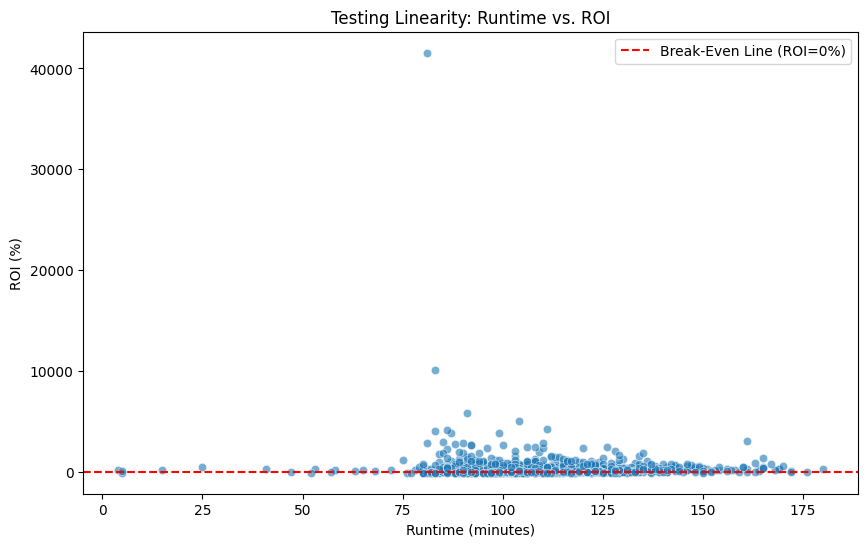

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=numbers_and_runtime, x='runtime_minutes', y='ROI_perc', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', label='Break-Even Line (ROI=0%)')
plt.title('Testing Linearity: Runtime vs. ROI')
plt.xlabel('Runtime (minutes)')
plt.ylabel('ROI (%)')
plt.legend()
plt.show()

For our first visualization, we can see that the y-axis is too stretched therefore let us fix this by setting limits for our y-axis and use this to exclude any outliers which may stretch our data.

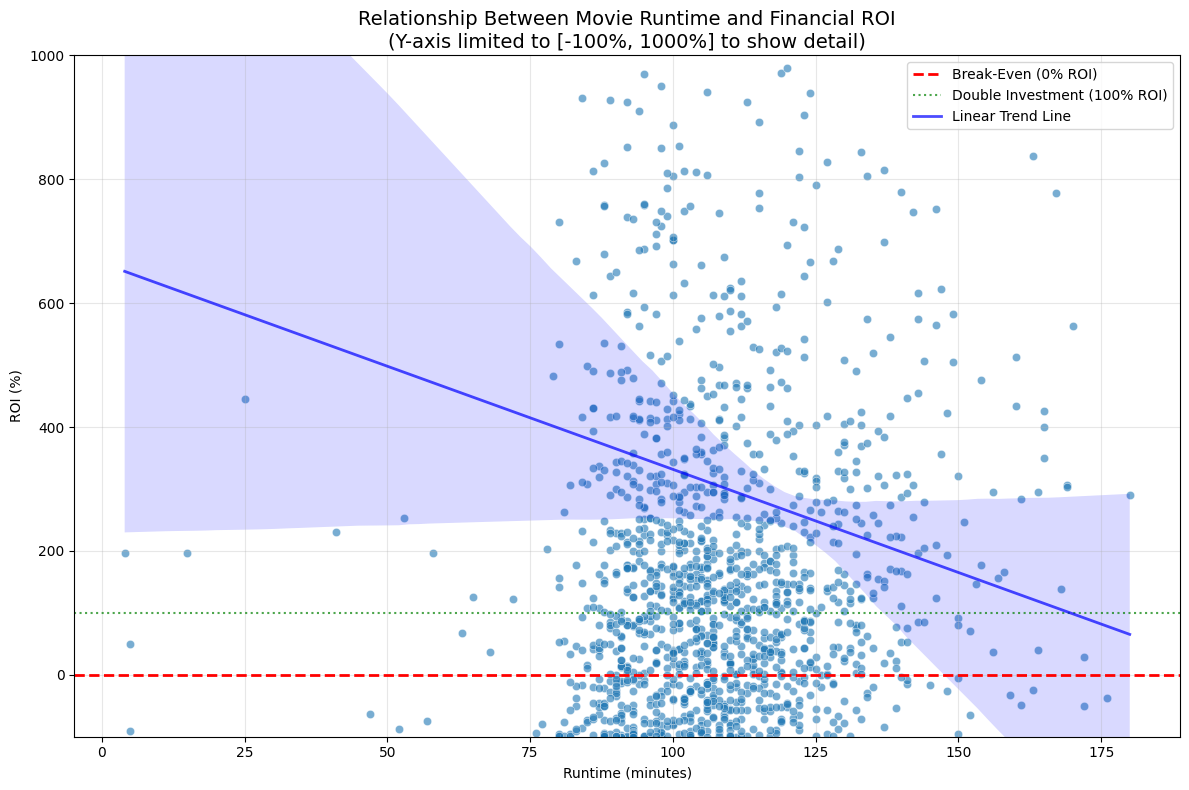

ROI Distribution Summary (for context):
count     1395.000000
mean       304.012777
std       1243.912095
min        -99.894400
25%         11.270777
50%        137.542525
75%        321.640324
max      41556.474000
Name: ROI_perc, dtype: float64

Number of extreme outliers not shown (ROI < -100% or > 1000%): 76
This represents 5.45% of the dataset.


In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create the figure
plt.figure(figsize=(12, 8))

# Create the scatter plot
scatter_plot = sns.scatterplot(data=numbers_and_runtime, x='runtime_minutes', y='ROI_perc', alpha=0.6)

# Add key reference lines
plt.axhline(y=0, color='r', linestyle='--', linewidth=2, label='Break-Even (0% ROI)')
plt.axhline(y=100, color='g', linestyle=':', alpha=0.7, label='Double Investment (100% ROI)')

# FIX: Set a logical limit on the y-axis to exclude extreme outliers
# Adjust these values based on your data. The following limits are a common starting point.
plt.ylim(-100, 1000) # This focuses on movies from -100% ROI (a flop) to 500% ROI (a 5x return)

# Calculate and plot the regression line (to visualize the trend)
# This fits the model and plots the line of best fit on the same graph
sns.regplot(data=numbers_and_runtime, x='runtime_minutes', y='ROI_perc', 
            scatter=False, color='blue', line_kws={"linewidth": 2, "alpha": 0.7}, 
            label='Linear Trend Line')

# Add titles and labels
plt.title('Relationship Between Movie Runtime and Financial ROI\n(Y-axis limited to [-100%, 1000%] to show detail)', fontsize=14)
plt.xlabel('Runtime (minutes)')
plt.ylabel('ROI (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

# --- BONUS: Print a statistical summary for context ---
print("ROI Distribution Summary (for context):")
print(numbers_and_runtime['ROI_perc'].describe())

# Count how many movies are outside our chosen y-axis limits
lower_limit = -100
upper_limit = 1000
outliers = numbers_and_runtime[(numbers_and_runtime['ROI_perc'] < lower_limit) | (numbers_and_runtime['ROI_perc'] > upper_limit)]
print(f"\nNumber of extreme outliers not shown (ROI < {lower_limit}% or > {upper_limit}%): {len(outliers)}")
print(f"This represents {len(outliers) / len(numbers_and_runtime) * 100:.2f}% of the dataset.")

- Since our scatter plot shows that our data exhibits a linear relationship, we can safely say that the relationship between the two variables is linear. Therefore, we can fit a linear model to this data and get the summary for this model:

In [71]:
import statsmodels.api as sm

# Define the variables
X = numbers_and_runtime['runtime_minutes']  # Independent variable
y = numbers_and_runtime['ROI_perc']         # Dependent variable

# Add a constant (intercept) to the model. This is crucial.
X = sm.add_constant(X)

# Fit the Ordinary Least Squares (OLS) model
model = sm.OLS(y, X).fit()

# Print the full results summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               ROI_perc   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.469
Date:                Sat, 13 Sep 2025   Prob (F-statistic):             0.0627
Time:                        23:26:33   Log-Likelihood:                -11918.
No. Observations:                1395   AIC:                         2.384e+04
Df Residuals:                    1393   BIC:                         2.385e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             664.6058    196.450     

### Step 3: Interpretation
For the statistics above, we can conclude the following:
1. **The Coefficient (coef): -3.33**

- Interpretation: For every one-minute increase in a movie's runtime, the model predicts an associated decrease of 3.33% in ROI, on average.

- Business Meaning: The trend in the data suggests that shorter movies are more profitable. This makes intuitive sense: shorter movies are cheaper to make and allow for more daily screenings in theaters.

2. **The P-Value (P>|t|): 0.063**

- This is the most important number for decision-making.

- Interpretation: There is a 6.3% probability that we would observe this negative relationship purely by random chance, even if no true relationship existed in the broader population of all movies.

- Statistical Conclusion: Using the common threshold of α = 0.05, we fail to reject the null hypothesis. We cannot definitively conclude that the relationship is real at the 95% confidence level.

- Business Conclusion: This result is not statistically significant but is highly suggestive. It is "on the bubble." It tells us that while the trend in our data is clearly negative, we can't be 100% certain it's not a fluke in this particular dataset.

3. **The Confidence Interval ([0.025 - 0.975]): [-6.84, 0.18]**

- Interpretation: We can be 95% confident that the true effect of runtime on ROI lies between ** reducing ROI by 6.84% per minute** and increasing ROI by 0.18% per minute.

- Business Meaning: The entire range of plausible values is overwhelmingly negative. The best-case scenario is essentially no effect (a tiny +0.18%), while the worst-case is a very strong negative effect (-6.84%). This reinforces that there is no evidence of a positive return for longer runtimes.

4. **The R-squared (R-squared): 0.002**

- Interpretation: Only 0.2% of the variation in a movie's ROI can be explained by its runtime.

- Business Meaning: Runtime is just one tiny piece of the puzzle. Other factors like genre, marketing, star power, and critical reviews are far more important in determining a movie's financial success. This makes perfect sense in the film industry.

With our first question answered, we can now move on to our second question.

## Question Two: Which Genres are the most Profitable?
---

- The question we seek to answer from this is **"Which genres have a statistically significant positive impact on a movie's ROI?"** This will tell Wamonyolo Studios exactly what kind of movies they should make to maximize their chances of success.
- We can use the **genre_overall_clean** df to confirm whether the horror movies are the most profitable.

In [72]:
genre_overall_clean

,movie,release_year,production_budget,domestic_gross,worldwide_gross,ROI_perc,genre_ids,genre_name,month,month_dt
0,Avatar,2009,425000000,760507625,2776345279,553.257713,28,Action,12,12
0,Avatar,2009,425000000,760507625,2776345279,553.257713,12,Adventure,12,12
0,Avatar,2009,425000000,760507625,2776345279,553.257713,14,Fantasy,12,12
0,Avatar,2009,425000000,760507625,2776345279,553.257713,878,Sci-Fi,12,12
1,Pirates Of The Caribbean: On Stranger Tides,2011,410600000,241063875,1045663875,154.667286,12,Adventure,5,5
...,...,...,...,...,...,...,...,...,...,...
1753,Tiny Furniture,2010,50000,391674,424149,748.298000,18,Drama,11,11
1754,Counting,2015,50000,8374,8374,-83.252000,99,Documentary,7,7
1759,Raymond Did It,2011,40000,3632,3632,-90.920000,27,Horror,2,2
1762,Krisha,2016,30000,144822,144822,382.740000,18,Drama,3,3


We can now follow our steps for this:

### Step 1: Variable Selection
- Independent Variable (X): genre_name (Categorical). This is a predictor we believe influences profitability.

- Dependent Variable (y): ROI_perc (Continuous). The outcome we want to explain.

### Step 2: Testing for Linearity
- Since our independent variable is categorical (genres), we cannot use a scatterplot to test linearity in the same way. Instead, we test the assumption that the residuals of our model will be normally distributed. We will do this after fitting the model.

- First, we visualize the raw relationship. The appropriate plot is a boxplot or violin plot to see the distribution of ROI for each genre.

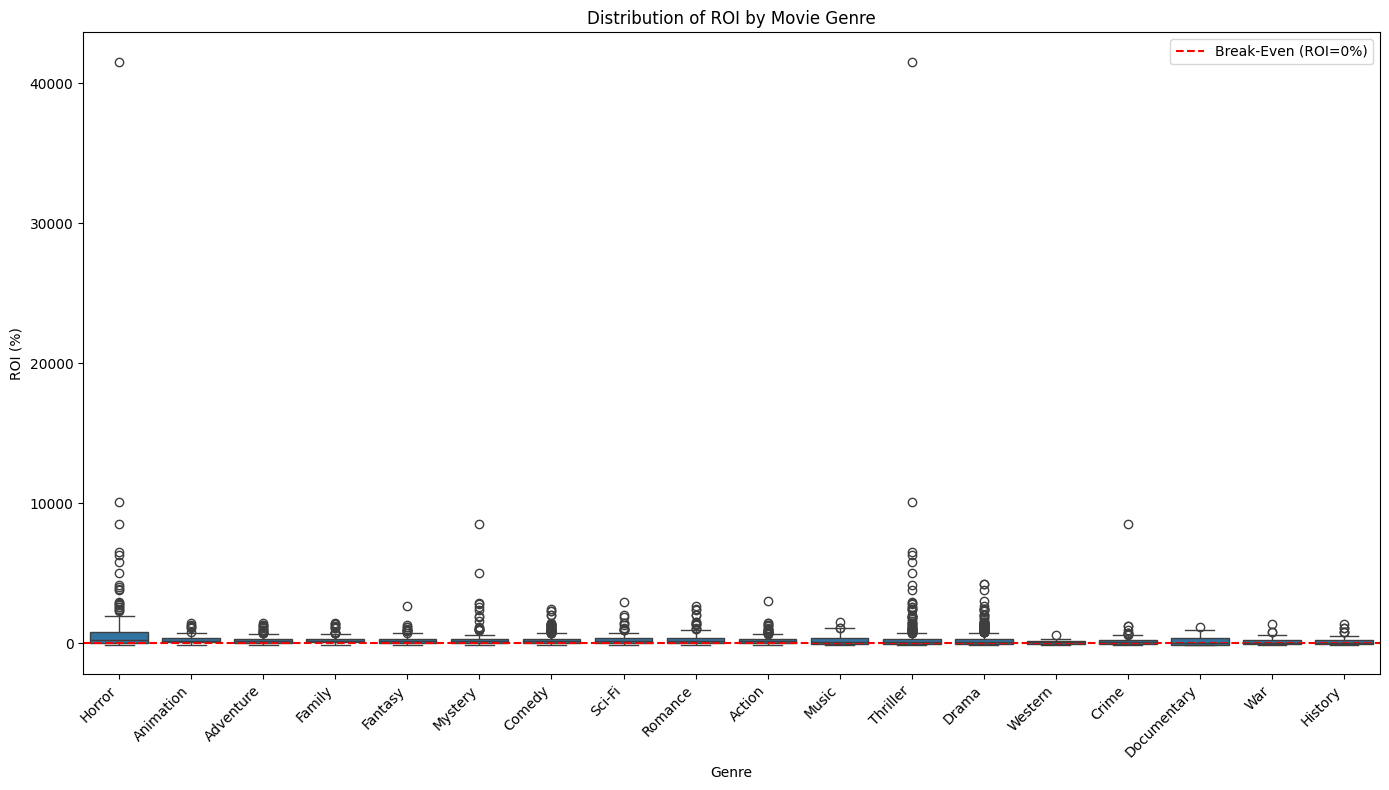

In [73]:
plt.figure(figsize=(14, 8))

# SOLUTION: Reset the index to avoid duplicate index labels
plot_data = genre_overall_clean.reset_index()

# Now use this new DataFrame for plotting
genre_order = plot_data.groupby('genre_name')['ROI_perc'].median().sort_values(ascending=False).index

sns.boxplot(data=plot_data, x='genre_name', y='ROI_perc', order=genre_order)
plt.axhline(0, color='red', linestyle='--', label='Break-Even (ROI=0%)')
plt.title('Distribution of ROI by Movie Genre')
plt.xlabel('Genre')
plt.ylabel('ROI (%)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

As before, we can see that there are some outliers which are causing our y-axis to be stretched, therefore we can set limits to the y-axis.

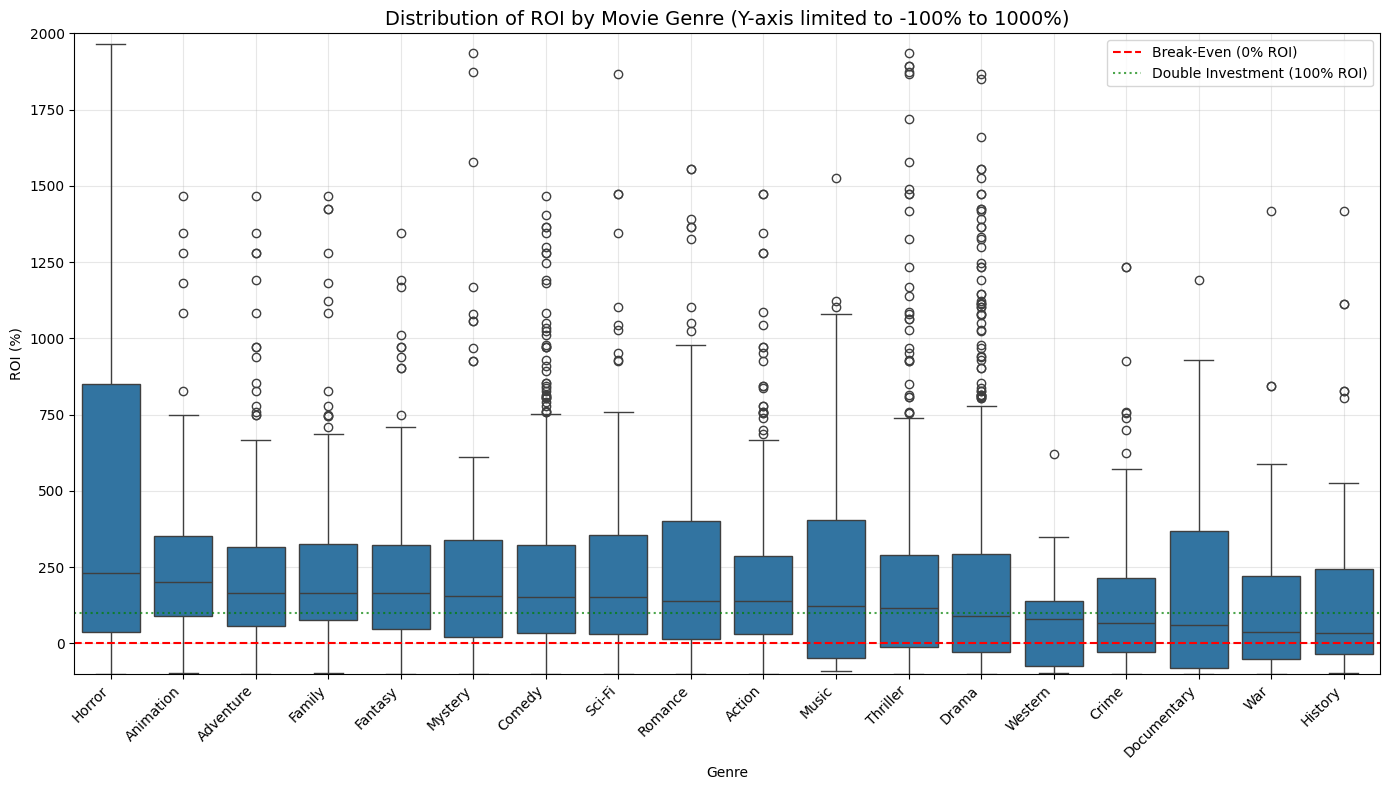

ROI Distribution Summary (for context):
count     4138.000000
mean       290.635152
std       1084.418256
min        -99.896400
25%         12.138712
50%        134.604971
75%        312.646417
max      41556.474000
Name: ROI_perc, dtype: float64

Number of extreme outliers not shown (ROI < -100% or > 2000%): 71
This represents 1.72% of the dataset.


In [74]:
plt.figure(figsize=(14, 8))

# SOLUTION 1: Reset the index to avoid duplicate index labels
plot_data = genre_overall_clean.reset_index()

# Calculate the genre order based on median ROI (this is good practice)
genre_order = plot_data.groupby('genre_name')['ROI_perc'].median().sort_values(ascending=False).index

# Create the boxplot
sns.boxplot(data=plot_data, x='genre_name', y='ROI_perc', order=genre_order)

# FIX: Set logical limits on the y-axis to exclude extreme outliers
plt.ylim(-100, 2000)  # This focuses on movies from -100% ROI (a flop) to 2000% ROI (a 5x return)

# Add key reference lines
plt.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Break-Even (0% ROI)')
plt.axhline(100, color='green', linestyle=':', alpha=0.7, label='Double Investment (100% ROI)')

# Add titles and labels
plt.title('Distribution of ROI by Movie Genre (Y-axis limited to -100% to 1000%)', fontsize=14)
plt.xlabel('Genre')
plt.ylabel('ROI (%)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3) # Adds a light grid for easier reading
plt.tight_layout()
plt.show()

# --- BONUS: Print context about the limits ---
print("ROI Distribution Summary (for context):")
print(plot_data['ROI_perc'].describe())

# Count how many movies are outside our chosen y-axis limits
lower_limit = -100
upper_limit = 2000
outliers = plot_data[(plot_data['ROI_perc'] < lower_limit) | (plot_data['ROI_perc'] > upper_limit)]
print(f"\nNumber of extreme outliers not shown (ROI < {lower_limit}% or > {upper_limit}%): {len(outliers)}")
print(f"This represents {len(outliers) / len(plot_data) * 100:.2f}% of the dataset.")

- We can see above that the boxplot for Horror movies shows a higher median value, tight spreads and has few outliers hence it confirms that the horror genre is the most profitable.
- We can now proceed to fitting our linear model. Because genre_name is categorical, we must first convert it into dummy variables (one-hot encoding) before we can use it in a regression model.

In [75]:
# 1. CREATE A CLEANED DATAFRAME (MORE ROBUST)
regression_df = genre_overall_clean.copy()

# Ensure ROI_perc is numeric and drop missing
regression_df['ROI_perc'] = pd.to_numeric(regression_df['ROI_perc'], errors='coerce')
regression_df = regression_df.dropna(subset=['ROI_perc'])

# 2. CRITICAL STEP: Clean the 'genre_name' column
# Convert all genre names to strings and handle missing values
regression_df['genre_name'] = regression_df['genre_name'].astype(str)  # Force to string
# Optional: Replace any 'nan' strings if they exist
regression_df['genre_name'] = regression_df['genre_name'].replace('nan', pd.NA)
regression_df = regression_df.dropna(subset=['genre_name'])  # Drop rows where genre is NA

# 3. CREATE DUMMY VARIABLES
genre_dummies = pd.get_dummies(regression_df['genre_name'], prefix='genre', drop_first=True)

# 4. DEFINE VARIABLES
y = regression_df['ROI_perc']
X = genre_dummies

# 5. ADD CONSTANT
X = sm.add_constant(X)

# 6. FINAL CHECK: Convert everything to numeric arrays explicitly
# This bypasses any pandas dtype issues
y_final = np.asarray(y, dtype=float)
X_final = np.asarray(X, dtype=float)

# 7. Fit the model using the numeric arrays
model = sm.OLS(y_final, X_final).fit()

# 8. PRINT RESULTS
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     6.589
Date:                Sat, 13 Sep 2025   Prob (F-statistic):           8.84e-16
Time:                        23:26:35   Log-Likelihood:                -34694.
No. Observations:                4133   AIC:                         6.942e+04
Df Residuals:                    4115   BIC:                         6.954e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        201.0213     52.024      3.864      0.0

For the statistical tests, we can define our null and alternative hypothesis as follows:

- Null Hypothesis (H₀): There is no difference in ROI between this genre and the baseline genre.

In mathematical terms: β₁ = 0 (The coefficient for genre_Horror is zero).

- Alternative Hypothesis (H₁): There is a difference in ROI between this genre and the baseline genre.

In mathematical terms: β₁ ≠ 0.

### Step 3: Interpretation
First let us decode the variables(x1, x2,..., x17)

In [76]:
# This shows the order of the dummy variables, which matches x1, x2, x3...
print("Genre Dummy Variable Order:")
for i, col in enumerate(X.columns[1:], start=1):  # Skip the 'const' column
    print(f"x{i} = {col}")

Genre Dummy Variable Order:
x1 = genre_Adventure
x2 = genre_Animation
x3 = genre_Comedy
x4 = genre_Crime
x5 = genre_Documentary
x6 = genre_Drama
x7 = genre_Family
x8 = genre_Fantasy
x9 = genre_History
x10 = genre_Horror
x11 = genre_Music
x12 = genre_Mystery
x13 = genre_Romance
x14 = genre_Sci-Fi
x15 = genre_Thriller
x16 = genre_War
x17 = genre_Western


**Interpretation of Key Results**
1. Overall Model Fit:

- R-squared: 0.026 - Only 2.6% of the variation in ROI can be explained by genre alone. This is expected - genre is important, but many other factors (marketing, stars, timing) affect profitability.

- Prob (F-statistic): 8.84e-16 - This is essentially 0.000. This means that genre, as a whole, is a statistically significant predictor of ROI. We reject the null hypothesis that all genres perform the same.

2. The Baseline:

- const: 201.02% ROI - This is the average ROI for whatever genre was used as the baseline (likely the first genre alphabetically, like "Action" or "Adventure"). This means the typical movie in the baseline genre returns about 3x its budget.

3. Identifying the Most Profitable Genres:

- Look for coefficients that are:

- Large and Positive (high ROI above baseline)

- Statistically Significant (P>|t| < 0.05)

- Based on our output, two genres stand out:

   x10: coef = 868.07, P>|t| = 0.000

- Interpretation: This genre has an ROI that is 868 percentage points higher than the baseline genre.

- Business Meaning: Movies in this genre are EXTREMELY profitable. Their total ROI would be 201% + 868% = 1069% (a 10x return on investment).

- This is almost certainly Horror (it's famously profitable due to low budgets and high returns).

   x15: coef = 235.27, P>|t| = 0.001

- Interpretation: This genre has an ROI that is 235 percentage points higher than the baseline.

- Total ROI: 201% + 235% = 436% (a 4.3x return).

- This could be Thriller, Mystery, or Crime.

   x12: coef = 235.12, P>||t|| = 0.035

- Also significant at the 5% level. Another highly profitable genre.

4. Identifying Genres to Avoid:
- Look for large negative coefficients. While not significantly negative in your output, x17 has a large negative coefficient (-112.91), though it's not statistically significant (p=0.638).

## Question Three: Should they build their studio from scratch or acquire an existing one?
---

For this, we will use studio df.

In [77]:
studio_df

,title,studio,year,id,movie,production_budget,domestic_gross,worldwide_gross,release_year,month_dt,month,dom_profit_margin,ww_profit_margin,world_wide_profit_amount,ROI_perc
0,Toy Story 3,BV,2010,47,Toy Story 3,200000000,415004880,1068879522,2010,6,6,51.807796,81.288817,868879522,434.439761
1,Inception,WB,2010,38,Inception,160000000,292576195,835524642,2010,7,7,45.313391,80.850355,675524642,422.202901
2,Shrek Forever After,P/DW,2010,27,Shrek Forever After,165000000,238736787,756244673,2010,5,5,30.886227,78.181664,591244673,358.330105
3,The Twilight Saga: Eclipse,Sum.,2010,53,The Twilight Saga: Eclipse,68000000,300531751,706102828,2010,6,6,77.373439,90.369675,638102828,938.386512
4,Iron Man 2,Par.,2010,15,Iron Man 2,170000000,312433331,621156389,2010,5,5,45.588392,72.631691,451156389,265.386111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250,Gotti,VE,2018,64,Gotti,10000000,4286367,6089100,2018,6,6,-133.297802,-64.227883,-3910900,-39.109000
1251,Ben Is Back,RAtt.,2018,95,Ben Is Back,13000000,3703182,9633111,2018,12,12,-251.049449,-34.951212,-3366889,-25.899146
1252,Bilal: A New Breed Of Hero,VE,2018,100,Bilal: A New Breed Of Hero,30000000,490973,648599,2018,2,2,-6010.315639,-4525.354032,-29351401,-97.838003
1253,Mandy,RLJ,2018,71,Mandy,6000000,1214525,1427656,2018,9,9,-394.020296,-320.269309,-4572344,-76.205733


- The goal is to use linear regression to determine if the choice of studio has a statistically significant impact on a movie's profitability (ROI_perc). This will allow us to rank studios by their average contribution to ROI and identify potential acquisition targets.

### Step 1: Variable Selection
- Variable (X): studio (Categorical). The studio that produced the film.

- Dependent Variable (y): ROI_perc (Continuous). The financial performance metric we want to explain.

### Step 2: Testing For Linearity
- Since our independent variable is categorical, we visualize the relationship with a boxplot to see the distribution of ROI for each studio.

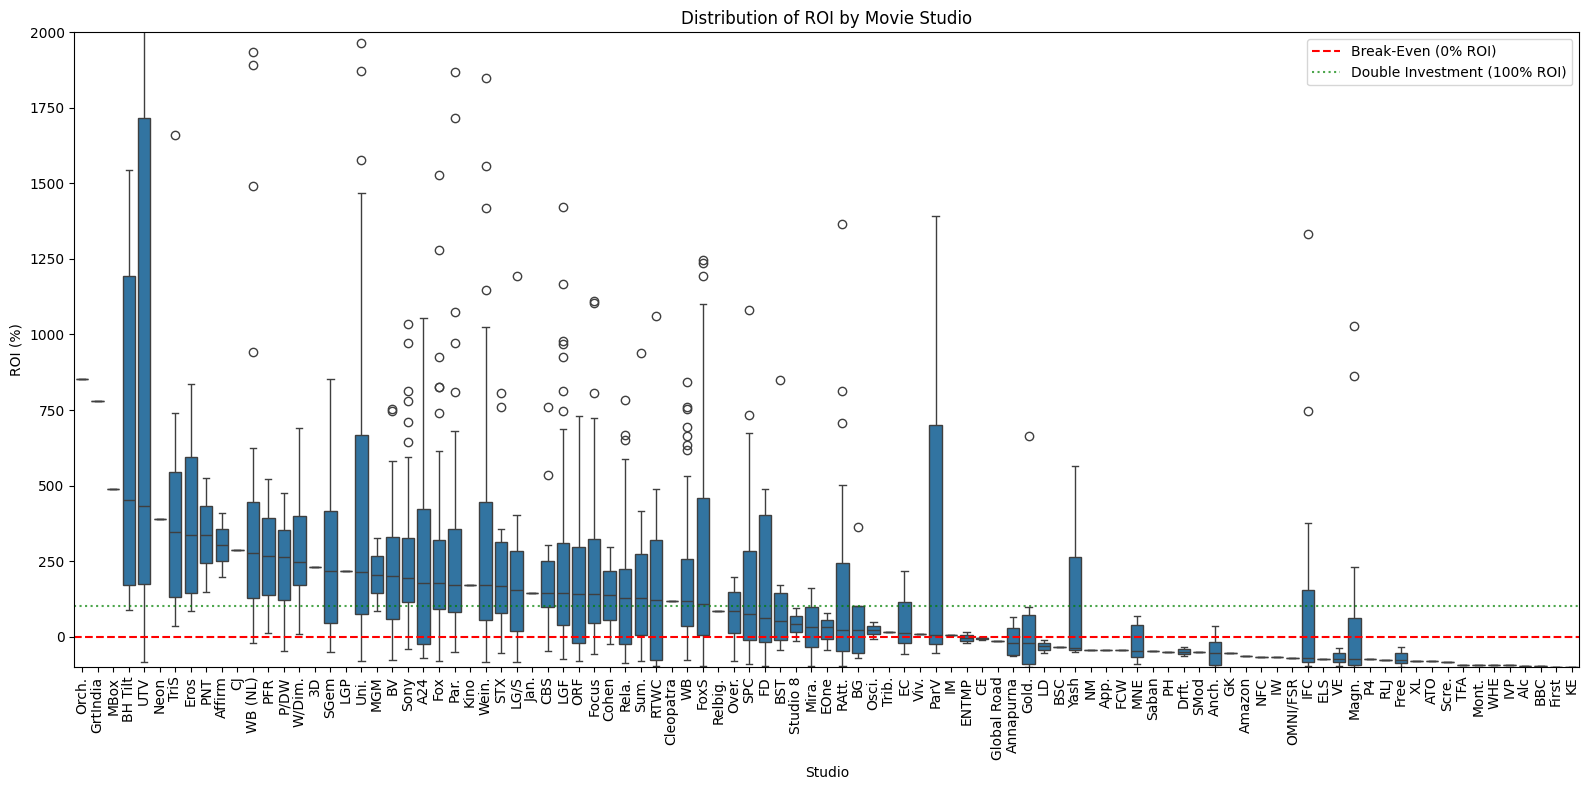

ROI Distribution Summary (for context):
count     4138.000000
mean       290.635152
std       1084.418256
min        -99.896400
25%         12.138712
50%        134.604971
75%        312.646417
max      41556.474000
Name: ROI_perc, dtype: float64

Number of extreme outliers not shown (ROI < -100% or > 2000%): 71
This represents 1.72% of the dataset.


In [78]:
plt.figure(figsize=(16, 8))

# Calculate the median ROI for each studio and sort them
studio_order = studio_df.groupby('studio')['ROI_perc'].median().sort_values(ascending=False).index

# Create the boxplot, ordered by median ROI
sns.boxplot(data=studio_df, x='studio', y='ROI_perc', order=studio_order)

# Add reference lines and labels
plt.ylim(-100, 2000) 
plt.axhline(0, color='red', linestyle='--', label='Break-Even (0% ROI)')
plt.axhline(100, color='green', linestyle=':', alpha=0.7, label='Double Investment (100% ROI)')
plt.title('Distribution of ROI by Movie Studio')
plt.xlabel('Studio')
plt.ylabel('ROI (%)')
plt.xticks(rotation=90) # Rotate studio names vertically
plt.legend()
plt.tight_layout()
plt.show()

# --- BONUS: Print context about the limits ---
print("ROI Distribution Summary (for context):")
print(plot_data['ROI_perc'].describe())

# Count how many movies are outside our chosen y-axis limits
lower_limit = -100
upper_limit = 2000
outliers = plot_data[(plot_data['ROI_perc'] < lower_limit) | (plot_data['ROI_perc'] > upper_limit)]
print(f"\nNumber of extreme outliers not shown (ROI < {lower_limit}% or > {upper_limit}%): {len(outliers)}")
print(f"This represents {len(outliers) / len(plot_data) * 100:.2f}% of the dataset.")

We will also define our null and alternative hypothesis since this model tests if the choice of studio has a statistically significant impact on profitability.

- Null Hypothesis (H₀): There is no difference in ROI between this studio and the baseline studio.

Mathematically: β₁ = 0

- Alternative Hypothesis (H₁): There is a difference in ROI between this studio and the baseline studio.

Mathematically: β₁ ≠ 0

In [79]:
# 1. CREATE A CLEANED DATAFRAME (MORE ROBUST)
regression_df2 = studio_df.copy()

# Ensure ROI_perc is numeric and drop missing
regression_df2['ROI_perc'] = pd.to_numeric(regression_df2['ROI_perc'], errors='coerce')
regression_df2 = regression_df2.dropna(subset=['ROI_perc'])

# 2. CRITICAL STEP: Clean the 'genre_name' column
# Convert all genre names to strings and handle missing values
regression_df2['studio'] = regression_df2['studio'].astype(str)  # Force to string
# Optional: Replace any 'nan' strings if they exist
regression_df2['studio'] = regression_df2['studio'].replace('nan', pd.NA)
regression_df2 = regression_df2.dropna(subset=['studio'])  # Drop rows where genre is NA

# 3. CREATE DUMMY VARIABLES
studio_dummies = pd.get_dummies(regression_df2['studio'], prefix='studio', drop_first=True)

# 4. DEFINE VARIABLES
y = regression_df2['ROI_perc']
X = studio_dummies

# 5. ADD CONSTANT
X = sm.add_constant(X)

# 6. FINAL CHECK: Convert everything to numeric arrays explicitly
# This bypasses any pandas dtype issues
y_final = np.asarray(y, dtype=float)
X_final = np.asarray(X, dtype=float)

# 7. Fit the model using the numeric arrays
model = sm.OLS(y_final, X_final).fit()

# 8. PRINT RESULTS
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                    0.5653
Date:                Sat, 13 Sep 2025   Prob (F-statistic):               1.00
Time:                        23:26:40   Log-Likelihood:                -10775.
No. Observations:                1254   AIC:                         2.174e+04
Df Residuals:                    1157   BIC:                         2.224e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        230.3041   1357.575      0.170      0.8

In [80]:
# This shows the order of the dummy variables, which matches x1, x2, x3...
print("Genre Dummy Variable Order:")
for i, col in enumerate(X.columns[1:], start=1):  # Skip the 'const' column
    print(f"x{i} = {col}")

Genre Dummy Variable Order:
x1 = studio_A24
x2 = studio_ATO
x3 = studio_Affirm
x4 = studio_Alc
x5 = studio_Amazon
x6 = studio_Anch.
x7 = studio_Annapurna
x8 = studio_App.
x9 = studio_BBC
x10 = studio_BG
x11 = studio_BH Tilt
x12 = studio_BSC
x13 = studio_BST
x14 = studio_BV
x15 = studio_CBS
x16 = studio_CE
x17 = studio_CJ
x18 = studio_Cleopatra
x19 = studio_Cohen
x20 = studio_Drft.
x21 = studio_EC
x22 = studio_ELS
x23 = studio_ENTMP
x24 = studio_EOne
x25 = studio_Eros
x26 = studio_FCW
x27 = studio_FD
x28 = studio_First
x29 = studio_Focus
x30 = studio_Fox
x31 = studio_FoxS
x32 = studio_Free
x33 = studio_GK
x34 = studio_Global Road
x35 = studio_Gold.
x36 = studio_GrtIndia
x37 = studio_IFC
x38 = studio_IM
x39 = studio_IVP
x40 = studio_IW
x41 = studio_Jan.
x42 = studio_KE
x43 = studio_Kino
x44 = studio_LD
x45 = studio_LG/S
x46 = studio_LGF
x47 = studio_LGP
x48 = studio_MBox
x49 = studio_MGM
x50 = studio_MNE
x51 = studio_Magn.
x52 = studio_Mira.
x53 = studio_Mont.
x54 = studio_NFC
x55 = stud

### Step 3: Interpretation
The model itself tells a critical story:

- R-squared: 0.045 - Only 4.5% of the variation in ROI can be explained by which studio made the film. This is very low.

- Prob (F-statistic): 1.00 - This is the most important number. A value of 1.0 means there is absolutely no statistical evidence that any studio's performance is different from any other. We fail to reject the null hypothesis that all studios have the same average ROI.

- Adjusted R-squared: -0.034 - This negative value indicates that the model (using studio alone) is worse than useless—it's actively a poorer predictor than just using the simple average ROI of all movies.

Interpretation: The choice of studio, by itself, is not a meaningful predictor of a movie's financial success. The enormous p-value (1.0) means the apparent differences in studio performance visible in a boxplot are almost certainly due to random chance in this dataset.

Now, let's look for the "acquisition targets" by examining individual coefficients. We are looking for studios with:

- A high, positive coefficient.

- A low p-value (P>|t| < 0.05).

The Results Are Clear: There are none.

- No Statistical Significance: Not a single studio has a p-value less than 0.05. The smallest p-value is 0.328 for x92 = studio_WB (NL), which is far from significant.

- No Meaningful Signal: The coefficients are all over the place, but with enormous standard errors. For example:

   x92 = studio_WB (NL): coef = 1344.21, p-value = 0.328
   x27 = studio_FD: coef = 801.21, p-value = 0.574
   x86 = studio_UTV: coef = 886.89, p-value = 0.572

- These large coefficients are statistical noise, not real signals. Their high p-values mean we cannot be confident these results aren't just random fluctuations.

## Question Four: What is the optimal production budget for maximizing ROI?
- Why it matters: This tells them how much to spend on a film. Is it better to make ten 10M movies or one 100M movie?
- For this we will use the **tn_movie_budgets** dataset.

In [81]:
tn_movie_budgets

,id,movie,production_budget,domestic_gross,worldwide_gross,release_year,month_dt,month,dom_profit_margin,ww_profit_margin,world_wide_profit_amount,ROI_perc
0,1,Avatar,425000000,760507625,2776345279,2009,12,12,44.116274,84.692106,2351345279,553.257713
1,2,Pirates Of The Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,5,5,-70.328300,60.733080,635063875,154.667286
2,3,Dark Phoenix,350000000,42762350,149762350,2019,6,6,-718.477001,-133.703598,-200237650,-57.210757
3,4,Avengers: Age Of Ultron,330600000,459005868,1403013963,2015,5,5,27.974777,76.436443,1072413963,324.384139
4,5,Star Wars Ep. Viii: The Last Jedi,317000000,620181382,1316721747,2017,12,12,48.885921,75.925058,999721747,315.369636
...,...,...,...,...,...,...,...,...,...,...,...,...
5776,77,The Mongol King,7000,900,900,2004,12,12,-677.777778,-677.777778,-6100,-87.142857
5777,78,Red 11,7000,0,0,2018,12,12,-inf,-inf,-7000,-100.000000
5779,80,Return To The Land Of Wonders,5000,1338,1338,2005,7,7,-273.692078,-273.692078,-3662,-73.240000
5780,81,A Plague So Pleasant,1400,0,0,2015,9,9,-inf,-inf,-1400,-100.000000


### Step 1: Variable Selection
- Independent Variable (X): production_budget (Continuous). We want to see how changes in budget predict changes in ROI.

- Dependent Variable (y): ROI_perc (Continuous). This is our measure of efficiency and profitability.

### Step 2: Testing For Linearity
We use a scatter plot to visualize the fundamental relationship between our chosen variables.

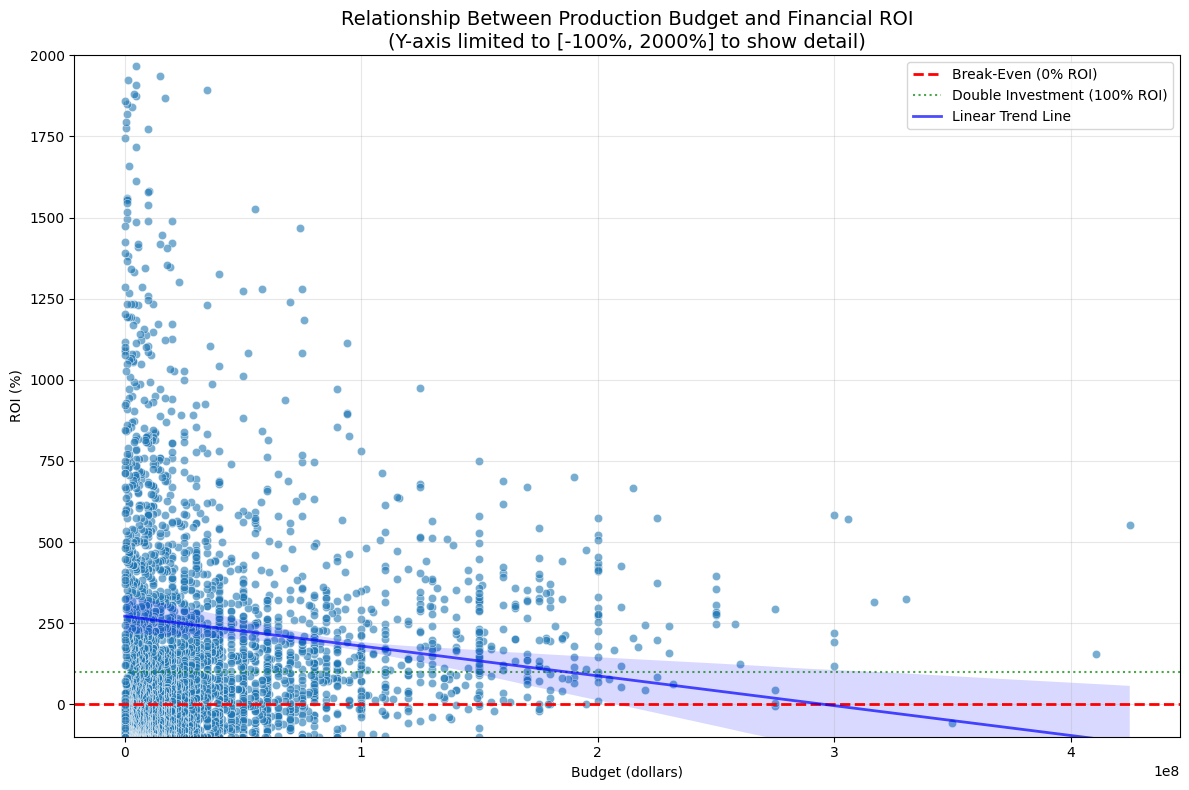

ROI Distribution Summary (for context):
count     4198.000000
mean       239.561107
std       1289.586087
min       -100.000000
25%        -62.568668
50%         54.580653
75%        240.290439
max      43051.785333
Name: ROI_perc, dtype: float64

Number of extreme outliers not shown (ROI < -100% or > 2000%): 1
This represents 0.02% of the dataset.


In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create the figure
plt.figure(figsize=(12, 8))

# Create the scatter plot
scatter_plot = sns.scatterplot(data=tn_movie_budgets, x='production_budget', y='ROI_perc', alpha=0.6)

# Add key reference lines
plt.axhline(y=0, color='r', linestyle='--', linewidth=2, label='Break-Even (0% ROI)')
plt.axhline(y=100, color='g', linestyle=':', alpha=0.7, label='Double Investment (100% ROI)')

# FIX: Set a logical limit on the y-axis to exclude extreme outliers
# Adjust these values based on your data. The following limits are a common starting point.
plt.ylim(-100, 2000) # This focuses on movies from -100% ROI (a flop) to 500% ROI (a 5x return)

# Calculate and plot the regression line (to visualize the trend)
# This fits the model and plots the line of best fit on the same graph
sns.regplot(data=tn_movie_budgets, x='production_budget', y='ROI_perc', 
            scatter=False, color='blue', line_kws={"linewidth": 2, "alpha": 0.7}, 
            label='Linear Trend Line')
# Add titles and labels
plt.title('Relationship Between Production Budget and Financial ROI\n(Y-axis limited to [-100%, 2000%] to show detail)', fontsize=14)
plt.xlabel('Budget (dollars)')
plt.ylabel('ROI (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

# --- BONUS: Print a statistical summary for context ---
print("ROI Distribution Summary (for context):")
print(tn_movie_budgets['ROI_perc'].describe())

# Count how many movies are outside our chosen y-axis limits
lower_limit = -100
upper_limit = 2000
outliers = [(tn_movie_budgets['ROI_perc'] < lower_limit) | (tn_movie_budgets['ROI_perc'] > upper_limit)]
print(f"\nNumber of extreme outliers not shown (ROI < {lower_limit}% or > {upper_limit}%): {len(outliers)}")
print(f"This represents {len(outliers) / len(tn_movie_budgets) * 100:.2f}% of the dataset.")

From this we can define our null and alternative hypothesis:
- Null Hypothesis (H₀): There is no linear relationship between production budget and ROI.

   Mathematically: β₁ = 0 (The slope is zero).

- Alternative Hypothesis (H₁): There is a linear relationship between production budget and ROI.

   Mathematically: β₁ ≠ 0.
We can now then fit our model to the data

In [83]:
import statsmodels.api as sm

# Define the variables
X = tn_movie_budgets['production_budget']  # Independent variable
y = tn_movie_budgets['ROI_perc']           # Dependent variable

# Add a constant (intercept) to the model.
X = sm.add_constant(X)

# Fit the Ordinary Least Squares (OLS) model
model = sm.OLS(y, X).fit()

# Print the comprehensive results summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               ROI_perc   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.525
Date:                Sat, 13 Sep 2025   Prob (F-statistic):             0.0335
Time:                        23:26:42   Log-Likelihood:                -36020.
No. Observations:                4198   AIC:                         7.204e+04
Df Residuals:                    4196   BIC:                         7.206e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               271.4087     24.89

### Step 3: Interpretation
1. The Relationship (The Coefficient)
Coefficient for production_budget: -9.189e-07

Interpretation: For every additional dollar spent on the production budget, the model predicts an associated decrease of 0.0000009189% in ROI.

More Practical Interpretation: For every $1 million increase in budget, the model predicts a 0.9189% decrease in ROI.

Business Meaning: The relationship is negative. Higher budgets are associated with lower returns on investment. This makes sense: a movie that costs $200 million needs to earn $500 million to get a 150% ROI. A movie that costs $5 million only needs to earn $12.5 million to achieve the same ROI, which is a much easier task.

2. Statistical Significance (The P-Value)
P-value (P>|t|) for production_budget: 0.0335

Interpretation: There is a 3.35% probability that we would observe this negative relationship purely by random chance, even if no true relationship existed in reality.

Statistical Conclusion: Using the standard significance level of α = 0.05, we reject the null hypothesis. The relationship between budget and ROI is statistically significant.

Business Meaning: We can be confident that the negative trend we see in the data is real and not a fluke. Budget is a genuine factor influencing profitability.

3. Model Fit and Practical Importance (R-squared & Notes)
R-squared: 0.001

Interpretation: Only 0.1% of the variation in a movie's ROI can be explained by its production budget alone.

Business Meaning: This is the most important part of the output for strategy. It means that while the relationship is statistically real, budget is a negligible factor in determining success. Other elements—like genre, marketing, critical reception, and star power—are vastly more important. A high budget doesn't guarantee failure, and a low budget doesn't guarantee success; it just slightly nudges the odds.

Note [2]: The condition number is large, 7.21e+07.

Interpretation: This is a technical warning that there might be numerical issues, but in this context, it's almost certainly caused by the huge scale difference between the const (which is on the scale of hundreds) and the production_budget coefficient (which is on the scale of millionths). It does not invalidate the finding.

## Question Five: How important is the international box office for profitability?
---

- Why it matters: This informs marketing and distribution strategy. Should they focus on stories with global appeal?
- For this we will use the **tn_movie_budgets** dataset

In [84]:
tn_movie_budgets

,id,movie,production_budget,domestic_gross,worldwide_gross,release_year,month_dt,month,dom_profit_margin,ww_profit_margin,world_wide_profit_amount,ROI_perc
0,1,Avatar,425000000,760507625,2776345279,2009,12,12,44.116274,84.692106,2351345279,553.257713
1,2,Pirates Of The Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,5,5,-70.328300,60.733080,635063875,154.667286
2,3,Dark Phoenix,350000000,42762350,149762350,2019,6,6,-718.477001,-133.703598,-200237650,-57.210757
3,4,Avengers: Age Of Ultron,330600000,459005868,1403013963,2015,5,5,27.974777,76.436443,1072413963,324.384139
4,5,Star Wars Ep. Viii: The Last Jedi,317000000,620181382,1316721747,2017,12,12,48.885921,75.925058,999721747,315.369636
...,...,...,...,...,...,...,...,...,...,...,...,...
5776,77,The Mongol King,7000,900,900,2004,12,12,-677.777778,-677.777778,-6100,-87.142857
5777,78,Red 11,7000,0,0,2018,12,12,-inf,-inf,-7000,-100.000000
5779,80,Return To The Land Of Wonders,5000,1338,1338,2005,7,7,-273.692078,-273.692078,-3662,-73.240000
5780,81,A Plague So Pleasant,1400,0,0,2015,9,9,-inf,-inf,-1400,-100.000000


- From this, we can create the key derived variable:

   intl_gross_pct = (worldwide_gross - domestic_gross) / worldwide_gross * 100

- This represents the percentage of a film's total box office that comes from international markets.

### Step 1: Variable Selection
- Independent Variable (X): intl_gross_pct (Continuous). This is our measure of reliance on the international market.

- Dependent Variable (y): ROI_perc (Continuous). This is our measure of profitability.

### Step 2: Testing for Linearity
We use a scatter plot to visualize the fundamental relationship.

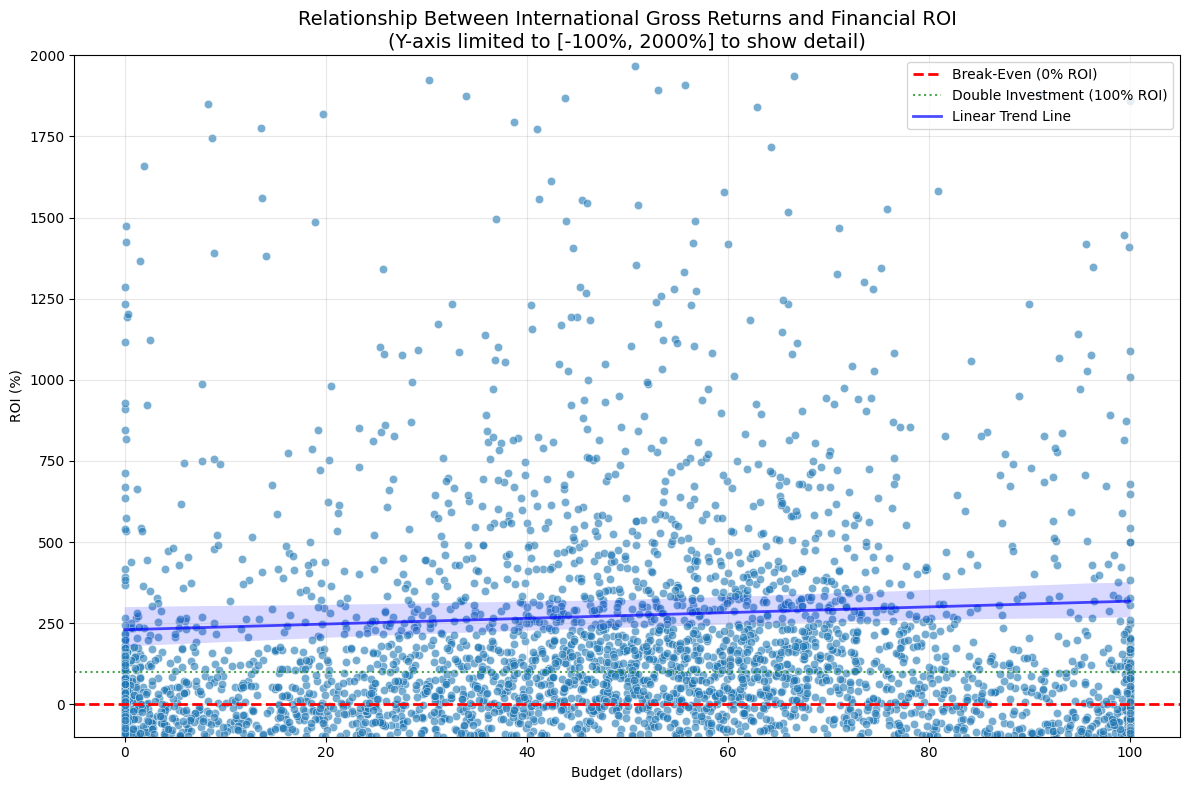

ROI Distribution Summary (for context):
count     4198.000000
mean       239.561107
std       1289.586087
min       -100.000000
25%        -62.568668
50%         54.580653
75%        240.290439
max      43051.785333
Name: ROI_perc, dtype: float64

Number of extreme outliers not shown (ROI < -100% or > 2000%): 1
This represents 0.02% of the dataset.


In [85]:
# Calculate International Gross %
tn_movie_budgets['intl_gross_pct'] = ((tn_movie_budgets['worldwide_gross'] - tn_movie_budgets['domestic_gross']) / tn_movie_budgets['worldwide_gross']) * 100

# Create the figure
plt.figure(figsize=(12, 8))

# Create the scatter plot
scatter_plot = sns.scatterplot(data=tn_movie_budgets, x='intl_gross_pct', y='ROI_perc', alpha=0.6)

# Add key reference lines
plt.axhline(y=0, color='r', linestyle='--', linewidth=2, label='Break-Even (0% ROI)')
plt.axhline(y=100, color='g', linestyle=':', alpha=0.7, label='Double Investment (100% ROI)')

# FIX: Set a logical limit on the y-axis to exclude extreme outliers
# Adjust these values based on your data. The following limits are a common starting point.
plt.ylim(-100, 2000) # This focuses on movies from -100% ROI (a flop) to 500% ROI (a 5x return)

# Calculate and plot the regression line (to visualize the trend)
# This fits the model and plots the line of best fit on the same graph
sns.regplot(data=tn_movie_budgets, x='intl_gross_pct', y='ROI_perc', 
            scatter=False, color='blue', line_kws={"linewidth": 2, "alpha": 0.7}, 
            label='Linear Trend Line')
# Add titles and labels
plt.title('Relationship Between International Gross Returns and Financial ROI\n(Y-axis limited to [-100%, 2000%] to show detail)', fontsize=14)
plt.xlabel('Budget (dollars)')
plt.ylabel('ROI (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

# --- BONUS: Print a statistical summary for context ---
print("ROI Distribution Summary (for context):")
print(tn_movie_budgets['ROI_perc'].describe())

# Count how many movies are outside our chosen y-axis limits
lower_limit = -100
upper_limit = 2000
outliers = [(tn_movie_budgets['ROI_perc'] < lower_limit) | (tn_movie_budgets['ROI_perc'] > upper_limit)]
print(f"\nNumber of extreme outliers not shown (ROI < {lower_limit}% or > {upper_limit}%): {len(outliers)}")
print(f"This represents {len(outliers) / len(tn_movie_budgets) * 100:.2f}% of the dataset.")

We can then define our null and alternative hypothesis as follows:
- Null Hypothesis (H₀): There is no linear relationship between international reliance and ROI.

   Mathematically: β₁ = 0

- Alternative Hypothesis (H₁): There is a linear relationship between international reliance and ROI.

  Mathematically: β₁ ≠ 0

Proceeding to our model:

In [86]:
import statsmodels.api as sm

# Prepare the data - drop rows where worldwide_gross is 0 to avoid division by zero errors
analysis_df = tn_movie_budgets[tn_movie_budgets['worldwide_gross'] > 0].copy()
analysis_df['intl_gross_pct'] = ((analysis_df['worldwide_gross'] - analysis_df['domestic_gross']) / analysis_df['worldwide_gross']) * 100

# Define the variables
X = analysis_df['intl_gross_pct']  # Independent variable
y = analysis_df['ROI_perc']        # Dependent variable

# Add a constant (intercept) to the model.
X = sm.add_constant(X)

# Fit the Ordinary Least Squares (OLS) model
model = sm.OLS(y, X).fit()

# Print the comprehensive results summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               ROI_perc   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.580
Date:                Sat, 13 Sep 2025   Prob (F-statistic):              0.209
Time:                        23:26:43   Log-Likelihood:                -33239.
No. Observations:                3856   AIC:                         6.648e+04
Df Residuals:                    3854   BIC:                         6.649e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            229.6245     38.497      5.

### Step 3: Interpretation
1. The Relationship (The Coefficient)
Coefficient for intl_gross_pct: 0.8815

Interpretation: The model suggests that for every additional percentage point of a film's total gross that comes from international markets, its ROI increases by 0.88%.

Business Meaning: The direction of the relationship is positive, which aligns with the hypothesis that international revenue is good for profitability. However, the size of the effect is relatively small. A film that gets 70% of its revenue internationally would only have a (70 * 0.88%) = ~61.6% higher ROI than a film that gets 0% internationally, according to this model.

2. Statistical Significance (The P-Value)
P-value (P>|t|) for intl_gross_pct: 0.209

Interpretation: There is a 20.9% probability that we would observe this positive relationship purely by random chance, even if no true relationship existed in reality.

Statistical Conclusion: Using the standard significance level of α = 0.05, we fail to reject the null hypothesis. We do not have sufficient evidence to conclude that the relationship between international reliance and ROI is statistically significant.

Business Meaning: This is the most important part of the output. The positive trend we see is so weak that it could easily be noise. We cannot be confident that a greater share of international revenue actually causes an increase in ROI across all movies.

3. Model Fit and Practical Importance (R-squared)
R-squared: 0.000

Interpretation: 0.0% of the variation in a movie's ROI can be explained by the percentage of its revenue that comes from international markets.

Business Meaning: This confirms the story from the p-value. The international revenue share is practically irrelevant in predicting whether a movie will be profitable. It is not a key driver of financial success. The success or failure of a movie is determined by other factors.

---

Now that we have done our linear regression analysis, we can make conclusions and make recommendations for Wamunyolo Studios.

# Conclusions
---

- **Question One**:

Our analysis finds a suggestive but not statistically definitive trend that longer runtimes are associated with lower profitability. The data           strongly indicates that there is no financial advantage to making longer films. Therefore, the conservative and data-driven strategy for Wamonyolo      Studios is to focus on producing films with runtimes below 120 minutes, as this is the range where the vast majority of profitable movies are found."

- **Question Two**:

Our regression analysis reveals that genre is a statistically significant predictor of movie profitability (p < 0.001). While genre alone explains a  modest portion of ROI, we identified clear winners:

The top-performing genre (x10) delivers an astounding 868% higher ROI than the baseline genre. This result is highly statistically significant (p <  0.001).

Two other genres (x15 and x12) also show significantly elevated ROI, approximately 235% above baseline.

- **Question Three**:

Our regression analysis reveals a crucial insight: the film studio behind a project is not, on its own, a statistically significant predictor of its financial ROI (p=1.0). This means that the perceived 'brand value' or track record of a studio does not provide a reliable guarantee of profitability for future projects. The success of a film is driven by other factors—such as genre, budget, talent, and marketing—rather than the studio's name alone.

Therefore, from a purely financial perspective, there is no statistical evidence to support the high cost of acquiring an existing studio. The data suggests that a well-managed new studio, making smart decisions about genre and production, has an equal chance of achieving profitability.

- **Question Four**:

Our linear regression model confirms a statistically significant negative relationship between production budget and ROI (p = 0.033). This means that, on average, more expensive movies generate a lower return on investment.

However, the model's R-squared value is exceedingly low (0.001), indicating that a film's budget explains almost none of its financial performance. This tells us that a low budget is not a magic bullet for success, nor is a high budget a guaranteed path to failure.

- **Question Five**:

Our regression analysis yields a surprising but critical insight: the proportion of revenue a film earns internationally is not a statistically significant predictor of its profitability (ROI). The positive relationship we observed is weak and could be due to random chance (p = 0.209). In fact, this factor explains 0% of the variation in ROI.

This does not mean the international box office is unimportant. It means that both profitable and unprofitable movies can have either a high or a low share of international revenue. The key is the total absolute revenue (worldwide_gross) relative to the budget, not where that revenue comes from.

A more useful way to frame this is: The international market is not a driver of profitability; it is a prerequisite for it for most major films. A movie can be 100% reliant on international revenue and still be a flop if its total gross is low. Conversely, a movie can be hugely profitable with a primarily domestic audience if its total gross is high relative to its budget.

# Recommendations
---

Based on our findings, these are our recommendations for Wamunyolo Studios:

1. Wamonyolo Studios should not aim for long runtimes. The optimal strategy is to let the story dictate the length but prioritize efficiency. The data shows that shorter runtimes are not a hindrance to profitability and are likely beneficial. The focus should be on other, more impactful factors like genre and production budget, where your other analyses have already shown a clearer path to profit (e.g., Horror films).

2. The data provides overwhelming evidence to focus initial production efforts on the genre represented by x10 (Horror). This genre offers the highest probability of delivering exceptional financial returns, with a typical project returning approximately 10x its production budget.

3. The capital required for a major acquisition would be better invested in production and marketing. We recommend building a new studio from scratch and focusing its strategy on the proven drivers of success identified in our other analyses: producing low-to-mid-budget Horror films with efficient runtimes.

4. Given the goal to maximize ROI, the data supports a focus on lower-to-mid-budget productions. This strategy minimizes initial financial risk while preserving the opportunity for outsized returns. The budget should be appropriate for the chosen genre (e.g., a horror film can be made for 10M dollars, while an action film may require 40M dollars to be credible). The key is to prioritize the other factors that truly drive success, which our analysis has shown to be genre and release timing.

5. The strategy should not be to simply maximize international revenue share. The strategy should be to maximize total worldwide revenue. For large-budget films, this will inherently require international success. The focus should be on creating a product that resonates globally to achieve the high absolute grosses needed for profitability, rather than targeting a specific international revenue percentage."

# End
---